In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import split, col, lit, udf, array, avg, lag, year, month
from pyspark.sql.types import IntegerType, DoubleType, ArrayType, StructType, StructField, FloatType, StringType
from pyspark.sql import functions as F, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.window import Window
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.dates import DateFormatter
from pyspark.ml.linalg import Vectors
from datetime import datetime, timedelta

In [42]:
spark = SparkSession.builder.appName("ProjectFinal").getOrCreate()
data = spark.read.csv("file:///home/minh/Desktop/Final_BigData_UIT/accident_data.csv", header = True, inferSchema = True)

data.printSchema()

root
 |-- Accident_Index: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: string (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-

# Min, Max, Trung vi, Trung binh, Pho bien

In [49]:
numeric_columns = ["Number_of_Vehicles", "Number_of_Casualties", "Speed_limit"]

df_double = data.select([F.col(col).cast(DoubleType()).alias(col) if col in numeric_columns else col for col in data.columns])

min_max_df = df_double.agg(*[F.min(col).alias(f"{col}_min") for col in numeric_columns],
                    *[F.max(col).alias(f"{col}_max") for col in numeric_columns])

min_max_rows = []
for col in numeric_columns:
    min_val = min_max_df.select(F.col(f"{col}_min")).first()[0]
    max_val = min_max_df.select(F.col(f"{col}_max")).first()[0]
    min_max_rows.append(Row(Column=col, Min_Value=min_val, Max_Value=max_val))

min_max_df_readable = spark.createDataFrame(min_max_rows)
min_max_df_readable.show()

+--------------------+---------+---------+
|              Column|Min_Value|Max_Value|
+--------------------+---------+---------+
|  Number_of_Vehicles|      1.0|     28.0|
|Number_of_Casualties|      1.0|     68.0|
|         Speed_limit|     10.0|     70.0|
+--------------------+---------+---------+



In [6]:
results = []

for col in data.columns:
    freq_df = data.groupBy(col).count().orderBy(F.col("count").desc())
    
    most_common = freq_df.first()
    most_common_value = most_common[0]
    most_common_count = most_common[1]
    
    least_common = freq_df.orderBy(F.col("count").asc()).first()
    least_common_value = least_common[0]
    least_common_count = least_common[1]
    
    results.append((col, most_common_value, most_common_count, least_common_value, least_common_count))

mode_df = spark.createDataFrame(results, ["Column", "Most_Common_Value", "Most_Common_Count", "Least_Common_Value", "Least_Common_Count"])
mode_df.show(34)

+--------------------+--------------------+-----------------+--------------------+------------------+
|              Column|   Most_Common_Value|Most_Common_Count|  Least_Common_Value|Least_Common_Count|
+--------------------+--------------------+-----------------+--------------------+------------------+
|      Accident_Index|            2.01E+12|           203663|       200501BS70192|                 1|
|Location_Easting_...|              533650|              116|              606890|                 1|
|Location_Northing...|              181050|              117|              485190|                 1|
|           Longitude|                NULL|              101|           -0.184017|                 1|
|            Latitude|                NULL|              101|            51.52561|                 1|
|        Police_Force|                   1|            73899|                  48|              1007|
|   Accident_Severity|                   3|           487161|                   1|

In [31]:
numeric_columns = ["Number_of_Vehicles", "Number_of_Casualties","Speed_limit"]

stats = []

for col in numeric_columns:
    mean_value = data.select(F.mean(col).alias("mean")).first()["mean"]
    median_value = data.approxQuantile(col, [0.5], 0.01)[0]
    stats.append((col, mean_value, median_value))

result_df = spark.createDataFrame(stats, ["Column", "Mean", "Median"])
result_df.show()

+--------------------+------------------+------+
|              Column|              Mean|Median|
+--------------------+------------------+------+
|  Number_of_Vehicles|1.8407732482355603|   2.0|
|Number_of_Casualties|1.3634842134625471|   1.0|
|         Speed_limit| 39.78832864628928|  30.0|
+--------------------+------------------+------+



# Tien xu ly du lieu

In [3]:
null_counts = []
for col in data.columns:
    null_count = data.select(F.sum(F.col(col).isNull().cast("int"))).first()[0]
    null_counts.append(Row(Column=col, Null_Count=null_count))

null_counts_df = spark.createDataFrame(null_counts)
null_counts_df.show(40)

+--------------------+----------+
|              Column|Null_Count|
+--------------------+----------+
|      Accident_Index|         0|
|Location_Easting_...|       101|
|Location_Northing...|       101|
|           Longitude|       101|
|            Latitude|       101|
|        Police_Force|         0|
|   Accident_Severity|         0|
|  Number_of_Vehicles|         0|
|Number_of_Casualties|         0|
|                Date|         0|
|         Day_of_Week|         0|
|                Time|        67|
|Local_Authority_(...|         0|
|Local_Authority_(...|         0|
|      1st_Road_Class|         0|
|     1st_Road_Number|         0|
|           Road_Type|         0|
|         Speed_limit|         0|
|     Junction_Detail|    570011|
|    Junction_Control|    236945|
|      2nd_Road_Class|         0|
|     2nd_Road_Number|         0|
|Pedestrian_Crossi...|        17|
|Pedestrian_Crossi...|        34|
|    Light_Conditions|         0|
|  Weather_Conditions|        20|
|Road_Surface_

In [43]:
data = data.drop("Junction_Detail", "Junction_Control", "LSOA_of_Accident_Location")
data = data.na.drop()

In [5]:
none_columns = []

for col in data.columns:
    none_count = data.filter(F.col(col) == "None").count()
    if none_count >= 100000:
        none_columns.append(col)

print("Columns with more than 100,000 null values:", none_columns)

24/12/14 19:40:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Columns with more than 100,000 null values: ['Special_Conditions_at_Site', 'Carriageway_Hazards']


In [44]:
data = data.drop("Special_Conditions_at_Site", "Carriageway_Hazards")

In [50]:
from pyspark.sql.functions import col, to_date, year, date_format, month

data = data.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))

In [46]:
quantiles = data.approxQuantile("Number_of_Casualties", [0.25, 0.75], 0.01)
Q1, Q3 = quantiles[0], quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data.filter((F.col("Number_of_Casualties") < lower_bound) | (F.col("Number_of_Casualties") > upper_bound))
print(f"Number of outliers: {outliers.count()}")

Number of outliers: 137344


In [47]:
data_clean = data.filter((F.col("Number_of_Casualties") >= lower_bound) & (F.col("Number_of_Casualties") <= upper_bound))

# Truc quan hoa du lieu

In [8]:
data.createOrReplaceTempView("road_accidents")

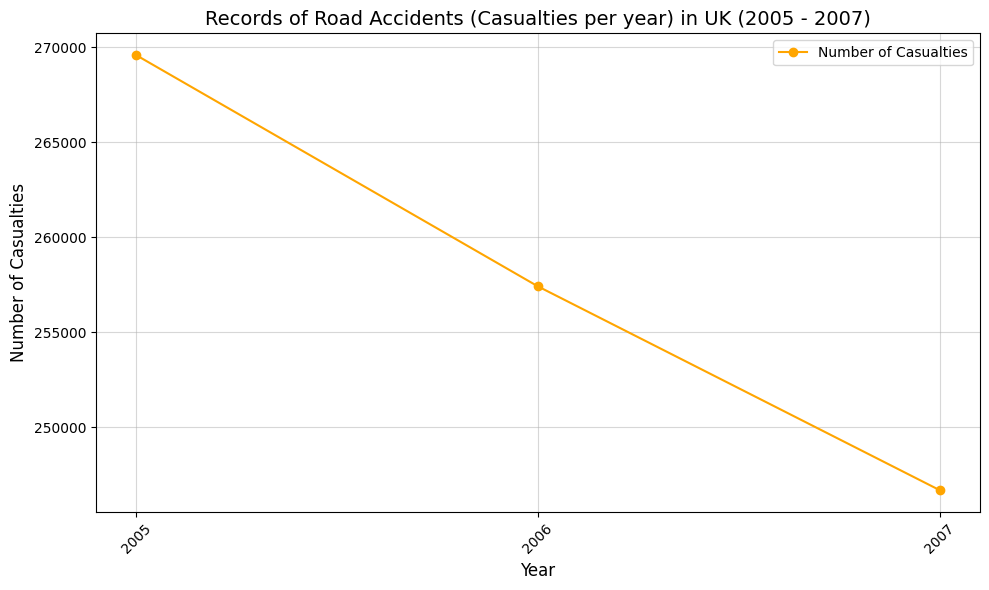

In [9]:
query = """
    SELECT 
        Year,
        SUM(Number_of_Casualties) as total_casualties,
        COUNT(Number_of_Casualties) as accident_count,
        AVG(Number_of_Casualties) as mean_casualties
    FROM road_accidents
    GROUP BY Year
    ORDER BY Year
"""
result_df = spark.sql(query)

result_pandas = result_df.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(
    result_pandas["Year"], 
    result_pandas["total_casualties"], 
    marker="o", color="orange", label="Number of Casualties"
)
plt.title("Records of Road Accidents (Casualties per year) in UK (2005 - 2007)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Casualties", fontsize=12)
plt.xticks(result_pandas["Year"], rotation=45)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()

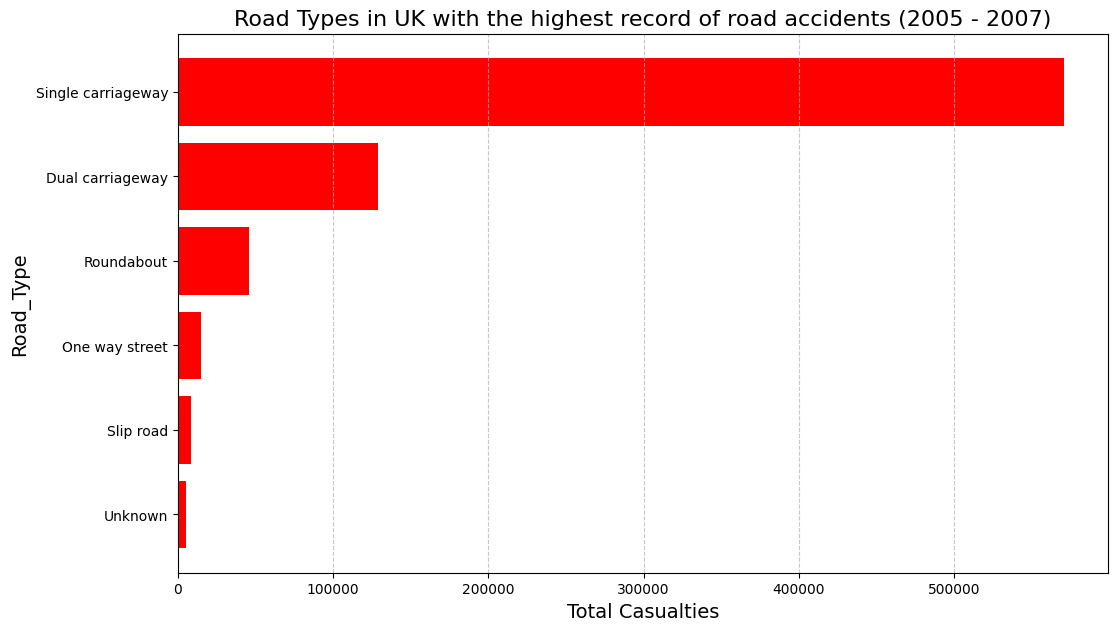

In [11]:
query = """
SELECT 
    Road_Type, 
    SUM(Number_of_Casualties) AS total_casualties
FROM road_accidents
GROUP BY Road_Type
ORDER BY total_casualties DESC
"""
road_agg = spark.sql(query)

road_agg_pd = road_agg.toPandas()

def visualize_road_type(df, column, color):
    plt.figure(figsize=(12, 7))
    plt.barh(df[column], df['total_casualties'], color=color)
    plt.xlabel('Total Casualties', fontsize=14)
    plt.ylabel(column, fontsize=14)
    plt.title('Road Types in UK with the highest record of road accidents (2005 - 2007)', fontsize=16)
    plt.gca().invert_yaxis()  # Đảo ngược trục y để hiển thị từ cao xuống thấp
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

visualize_road_type(road_agg_pd, column='Road_Type', color='red')

In [12]:
query_roadsurface = """
SELECT 
    Road_Surface_Conditions AS Conditions, 
    SUM(Number_of_Casualties) AS total_casualties
FROM road_accidents
GROUP BY Road_Surface_Conditions
"""
roadsurface_agg = spark.sql(query_roadsurface)

query_weather = """
SELECT 
    CASE 
        WHEN Weather_Conditions = 'Other' THEN 'Unknown' 
        ELSE Weather_Conditions 
    END AS Conditions, 
    SUM(Number_of_Casualties) AS total_casualties
FROM road_accidents
GROUP BY Weather_Conditions
"""
weather_agg = spark.sql(query_weather)

query_light = """
SELECT 
    Light_Conditions AS Conditions, 
    SUM(Number_of_Casualties) AS total_casualties
FROM road_accidents
GROUP BY Light_Conditions
"""
light_agg = spark.sql(query_light)



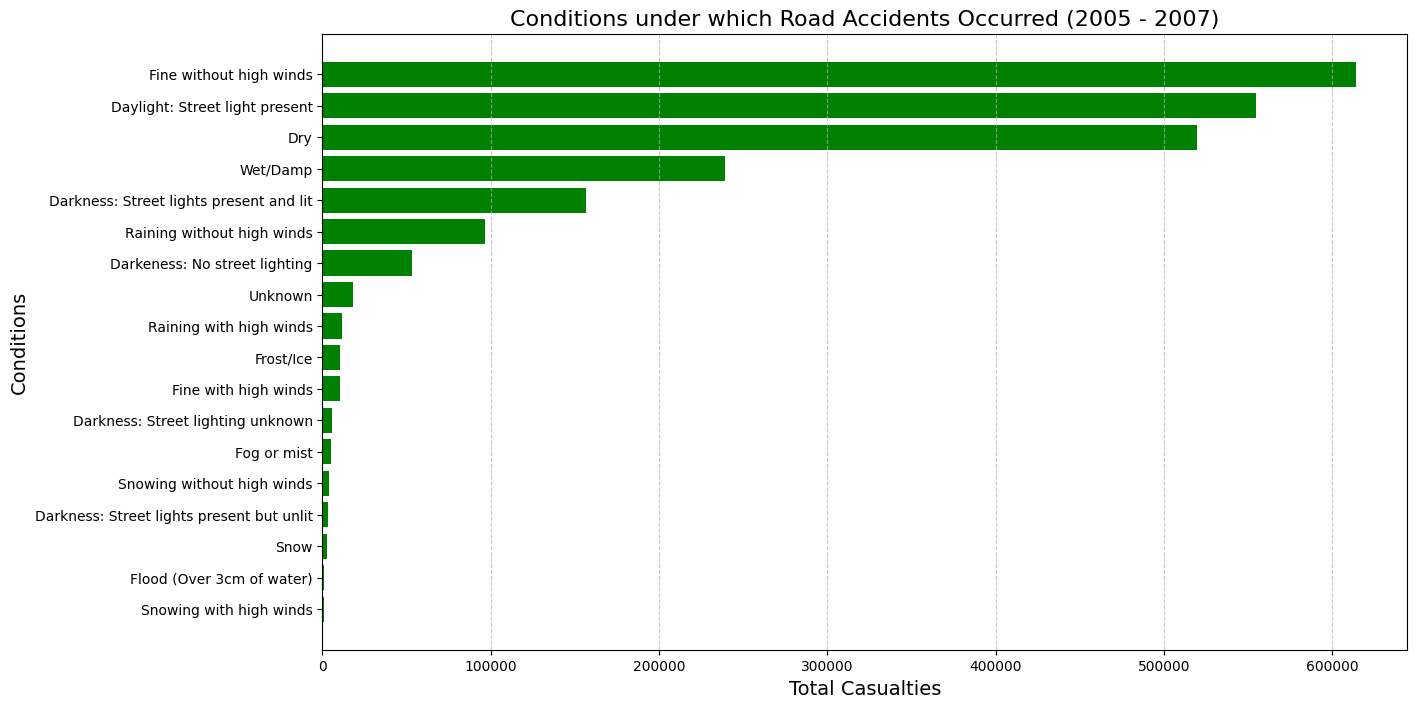

In [13]:
from pyspark.sql import DataFrame

def union_all(*dfs: DataFrame) -> DataFrame:
    return dfs[0].unionByName(dfs[1]) if len(dfs) == 2 else union_all(dfs[0].unionByName(dfs[1]), *dfs[2:])

condition_agg = union_all(roadsurface_agg, weather_agg, light_agg).orderBy("total_casualties", ascending=False)

condition_agg_pd = condition_agg.toPandas()


def visualize_conditions(df):
    plt.figure(figsize=(14, 8))
    plt.barh(df['Conditions'], df['total_casualties'], color='green')
    plt.xlabel('Total Casualties', fontsize=14)
    plt.ylabel('Conditions', fontsize=14)
    plt.title('Conditions under which Road Accidents Occurred (2005 - 2007)', fontsize=16)
    plt.gca().invert_yaxis()  # Đảo ngược trục y để hiển thị từ cao xuống thấp
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

visualize_conditions(condition_agg_pd)


In [14]:
severity_agg_sql = spark.sql("""
    SELECT 
        CASE 
            WHEN Accident_Severity = 1 THEN 'Fatal'
            WHEN Accident_Severity = 2 THEN 'Serious'
            WHEN Accident_Severity = 3 THEN 'Slight'
        END AS Accident_Severity,
        SUM(Number_of_Casualties) AS total_casualties
    FROM road_accidents
    GROUP BY Accident_Severity
    ORDER BY total_casualties
""")

area_agg_sql = spark.sql("""
    SELECT 
        CASE 
            WHEN Urban_or_Rural_Area = 1 THEN 'Urban'
            WHEN Urban_or_Rural_Area = 2 THEN 'Rural'
            WHEN Urban_or_Rural_Area = 3 THEN 'Unallocated'
        END AS Area_Type,
        SUM(Number_of_Casualties) AS total_casualties
    FROM road_accidents
    GROUP BY Urban_or_Rural_Area
    ORDER BY total_casualties
""")


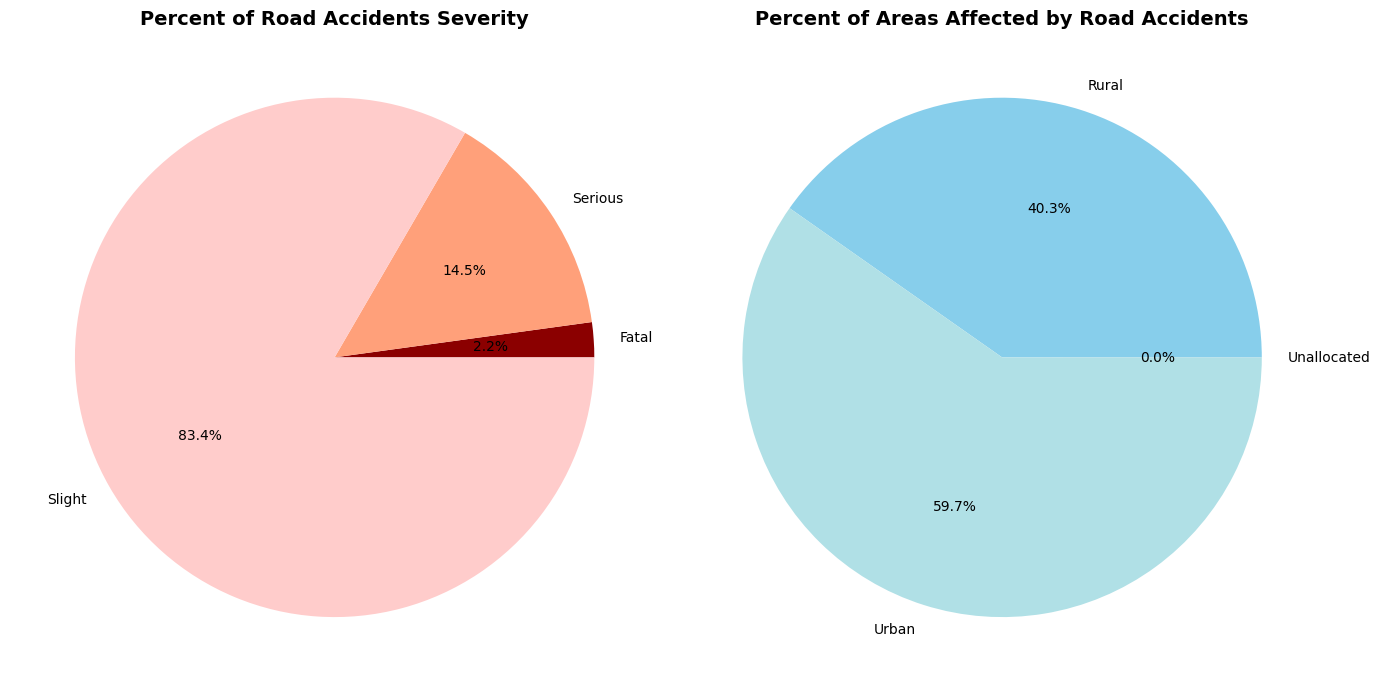

In [15]:
severity_agg_pd = severity_agg_sql.toPandas()
area_agg_pd = area_agg_sql.toPandas()

labels1 = severity_agg_pd["Accident_Severity"]
values1 = severity_agg_pd["total_casualties"]

labels2 = area_agg_pd["Area_Type"]
values2 = area_agg_pd["total_casualties"]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(values1, labels=labels1, autopct='%1.1f%%', colors=['#8b0000', '#ffa07a', '#ffcccb'])
axes[0].set_title('Percent of Road Accidents Severity', fontsize=14, weight='bold')

axes[1].pie(values2, labels=labels2, autopct='%1.1f%%', colors=['#4682b4', '#87ceeb', '#b0e0e6'])
axes[1].set_title('Percent of Areas Affected by Road Accidents', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()


# LSTM

In [51]:
from pyspark.sql.functions import col, to_date, year, date_format, month

data = data.withColumn("Date", to_date(col("Date"), "dd/MM/yyyy"))

df_uk_lstm = data.select('Date', 'Number_of_Casualties')

df_uk_agg = df_uk_lstm.groupBy('Date').agg(
    F.sum('Number_of_Casualties').alias('sum_Casualties')
)
df_uk_agg_sorted = df_uk_agg.orderBy('Date')

df_uk_agg_sorted.show(10)

+----------+--------------+
|      Date|sum_Casualties|
+----------+--------------+
|2005-01-01|           441|
|2005-01-02|           460|
|2005-01-03|           408|
|2005-01-04|           584|
|2005-01-05|           665|
|2005-01-06|           699|
|2005-01-07|           643|
|2005-01-08|           589|
|2005-01-09|           505|
|2005-01-10|           684|
+----------+--------------+
only showing top 10 rows



In [52]:
total_count = df_uk_agg_sorted.count()

train_count = int(total_count * 0.8)

train_data = df_uk_agg_sorted.limit(train_count)
test_data1 = df_uk_agg_sorted.subtract(train_data)


In [53]:
vector_assembler = VectorAssembler(inputCols=["sum_Casualties"], outputCol="Features")
df_with_features = vector_assembler.transform(df_uk_agg_sorted)

min_max = df_with_features.select(
    F.min("sum_Casualties").alias("min_value"),
    F.max("sum_Casualties").alias("max_value")
).first()

min_value = min_max["min_value"]
max_value = min_max["max_value"]

df_normalized = df_with_features.withColumn(
    "value_normalized",
    (col("sum_Casualties") - min_value) / (max_value - min_value)
)

assembler = VectorAssembler(inputCols=["value_normalized"], outputCol="Scaled_Features")
df_vectorized = assembler.transform(df_normalized)

normalized_df = df_vectorized.drop("value_normalized")
normalized_df.show(3)

+----------+--------------+--------+--------------------+
|      Date|sum_Casualties|Features|     Scaled_Features|
+----------+--------------+--------+--------------------+
|2005-01-01|           441| [441.0]|[0.21145374449339...|
|2005-01-02|           460| [460.0]|[0.23237885462555...|
|2005-01-03|           408| [408.0]|[0.1751101321585903]|
+----------+--------------+--------+--------------------+
only showing top 3 rows



In [54]:
normalized_df = normalized_df.withColumn("Year", year("Date"))

windowSpec = Window.partitionBy("Year").orderBy("Date")

def create_lagged_features(df, lag_count=50):
    for i in range(1, lag_count + 1):
        df = df.withColumn(f"lag_{i}", F.lag(df["Scaled_Features"], i).over(windowSpec))
    return df

lagged_df = create_lagged_features(normalized_df)
lagged_df = lagged_df.na.drop()  # Loại bỏ các giá trị NaN


In [55]:
total_count = lagged_df.count()

train_count = int(total_count * 0.8)

lagged_train_data = lagged_df.limit(train_count)
lagged_test_data = lagged_df.subtract(lagged_train_data)

lagged_train_data.show(3)

+----------+--------------+--------+--------------------+----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------

In [56]:
from pyspark.ml.param import Param, Params

class LSTMModel(Params):
    in_dim = Param(Params._dummy(), "in_dim", "Input dimension of the LSTM cell")
    hidden_dim = Param(Params._dummy(), "hidden_dim", "Hidden dimension of the LSTM cell")
    learn_rate = Param(Params._dummy(), "learn_rate", "Learning rate")
    num_epochs = Param(Params._dummy(), "num_epochs", "Number of epochs")

    def __init__(self, in_dim=None, hidden_dim=None, out_dim=None, learn_rate=None, num_epochs=None):
        super(LSTMModel, self).__init__()
        self._setDefault(in_dim=50, hidden_dim=256, learn_rate=0.00001, num_epochs=10)
        self.out_dim = out_dim
        self.lstm_weights = None
        self.lstm_weights_broadcast = None

        if in_dim is not None:
            self._set(in_dim=in_dim)
        if hidden_dim is not None:
            self._set(hidden_dim=hidden_dim)
        if learn_rate is not None:
            self._set(learn_rate=learn_rate)
        if num_epochs is not None:
            self._set(num_epochs=num_epochs)

    def initialize_lstm_weights(self):
        hidden_units = self.getOrDefault(self.hidden_dim)
        input_units = self.getOrDefault(self.in_dim)
        output_units = self.out_dim

        def generate_weights(rows, cols):
            return np.random.normal(size=(rows, cols))

        def generate_biases(size):
            return np.zeros(shape=(size, 1))

        input_weights = generate_weights(hidden_units, input_units + hidden_units)
        input_bias = generate_biases(hidden_units)

        forget_weights = generate_weights(hidden_units, input_units + hidden_units)
        forget_bias = generate_biases(hidden_units)

        output_weights = generate_weights(hidden_units, input_units + hidden_units)
        output_bias = generate_biases(hidden_units)

        cell_weights = generate_weights(hidden_units, input_units + hidden_units)
        cell_bias = generate_biases(hidden_units)

        output_layer_weights = generate_weights(output_units, hidden_units)
        output_layer_bias = generate_biases(output_units)

        return input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias

    def lstm_forward(self, xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias):
        concat = np.vstack((ht_prev, xt))

        it = self.activation_sigmoid(np.dot(input_weights, concat) + input_bias)
        ft = self.activation_sigmoid(np.dot(forget_weights, concat) + forget_bias)
        ot = self.activation_sigmoid(np.dot(output_weights, concat) + output_bias)

        ct_tilde = np.tanh(np.dot(cell_weights, concat) + cell_bias)
        ct = ft * ct_prev + it * ct_tilde
        ht = ot * np.tanh(ct)

        return ht, ct, it, ft, ot, ct_tilde

    def lstm_backward(self, dht, dct, xt, ht, ct, ht_prev, ct_prev, it, ft, ot, ct_tilde, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias):
        concat = np.vstack((ht_prev, xt))

        dot = dht * np.tanh(ct) * self.activation_sigmoid_derivative(ot)
        d_output_weights = np.dot(dot, concat.T)
        d_output_bias = dot

        dct += dht * ot * self.activation_tanh_derivative(np.tanh(ct))

        dft = dct * ct_prev * self.activation_sigmoid_derivative(ft)
        d_forget_weights = np.dot(dft, concat.T)
        d_forget_bias = dft

        dit = dct * ct_tilde * self.activation_sigmoid_derivative(it)
        d_input_weights = np.dot(dit, concat.T)
        d_input_bias = dit

        dct_tilde = dct * it * self.activation_tanh_derivative(ct_tilde)
        d_cell_weights = np.dot(dct_tilde, concat.T)
        d_cell_bias = dct_tilde
        return d_input_weights, d_input_bias, d_forget_weights, d_forget_bias, d_output_weights, d_output_bias, d_cell_weights, d_cell_bias
        
    def activation_sigmoid(self, input_value):
        return 1/(1 + np.exp(-input_value))

    def activation_sigmoid_derivative(self, sigmoid_output):
        return np.multiply(sigmoid_output, np.subtract(1, sigmoid_output))

    def activation_tanh(self, input_value):
        return np.tanh(input_value)

    def activation_tanh_derivative(self, tanh_output):
        return np.subtract(1, np.square(tanh_output))

    def map_gradient(self, row, lstm_weights):
        xt = np.array(row[4:], dtype=np.float32).reshape(self.getOrDefault(self.in_dim), 1)
        yt = np.array([row[1]], dtype=np.float32).reshape(self.out_dim, 1)

        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = lstm_weights

        ht_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))
        ct_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))

        ht, ct, it, ft, ot, ct_tilde = self.lstm_forward(xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)
        output = np.dot(output_layer_weights, ht) + output_layer_bias

        dout = output - yt
        d_output_layer_weights = np.dot(dout, ht.T)
        d_output_layer_bias = dout
        dht = np.dot(output_layer_weights.T, dout)
        dct = np.zeros_like(ct)

        d_input_weights, d_input_bias, d_forget_weights, d_forget_bias, d_output_weights, d_output_bias, d_cell_weights, d_cell_bias = self.lstm_backward(dht, dct, xt, ht, ct, ht_prev, ct_prev, it, ft, ot, ct_tilde, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)

        return [(d_input_weights, d_input_bias), (d_forget_weights, d_forget_bias), (d_output_weights, d_output_bias), (d_cell_weights, d_cell_bias), (d_output_layer_weights, d_output_layer_bias)]

    def _update_weights(self, gradients):
        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = self.lstm_weights

        d_input_weights, d_input_bias = gradients[0]
        d_forget_weights, d_forget_bias = gradients[1]
        d_output_weights, d_output_bias = gradients[2]
        d_cell_weights, d_cell_bias = gradients[3]
        d_output_layer_weights, d_output_layer_bias = gradients[4]

        input_weights -= self.getOrDefault(self.learn_rate) * d_input_weights
        input_bias -= self.getOrDefault(self.learn_rate) * d_input_bias
        forget_weights -= self.getOrDefault(self.learn_rate) * d_forget_weights
        forget_bias -= self.getOrDefault(self.learn_rate) * d_forget_bias
        output_weights -= self.getOrDefault(self.learn_rate) * d_output_weights
        output_bias -= self.getOrDefault(self.learn_rate) * d_output_bias
        cell_weights -= self.getOrDefault(self.learn_rate) * d_cell_weights
        cell_bias -= self.getOrDefault(self.learn_rate) * d_cell_bias
        output_layer_weights -= self.getOrDefault(self.learn_rate) * d_output_layer_weights
        output_layer_bias -= self.getOrDefault(self.learn_rate) * d_output_layer_bias

        self.lstm_weights = (input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias)

    def reduce_gradient(self, g1, g2):
        return [(a + c, b + d) for (a, b), (c, d) in zip(g1, g2)]

    def predict(self, row, lstm_weights):
        xt = np.array(row[1][1:], dtype=np.float32).reshape(self.getOrDefault(self.in_dim), 1)
        
        ht_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))
        ct_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))

        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = self.lstm_weights

        ht, ct, _, _, _, _ = self.lstm_forward(xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)
        output = np.dot(output_layer_weights, ht) + output_layer_bias

        return (row[0], float(output[0][0]), row[2])

    def predict_next90(self, xt, lstm_weights):        
        ht_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))
        ct_prev = np.zeros((self.getOrDefault(self.hidden_dim), 1))

        input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias, output_layer_weights, output_layer_bias = self.lstm_weights

        ht, ct, _, _, _, _ = self.lstm_forward(xt, ht_prev, ct_prev, input_weights, input_bias, forget_weights, forget_bias, output_weights, output_bias, cell_weights, cell_bias)
        output = np.dot(output_layer_weights, ht) + output_layer_bias

        return (float(output[0][0]))

    def train(self, lagged_train_data, lstm_weights):
        self.lstm_weights = lstm_weights

        for epoch in range(self.getOrDefault(self.num_epochs)):
            gradients = lagged_train_data.rdd \
                .map(lambda row: self.map_gradient(row, self.lstm_weights)) \
                .reduce(self.reduce_gradient)

            self._update_weights(gradients)

            print(f"Epoch {epoch+1}/{self.getOrDefault(self.num_epochs)} completed")


In [57]:
def create_lstm_model1(in_dim, hidden_dim, lr, epoch):
    return LSTMModel(
        in_dim=in_dim,
        hidden_dim=hidden_dim,
        learn_rate=lr,
        num_epochs=epoch,
        out_dim=1
    )

def evaluate_model(model, test_data, lstm_weights):
    test_data = test_data.select(
        col("Date"),
        array(col("Scaled_Features"), *[col(f"lag_{i}") for i in range(1, 51)]).alias("Features"),
        col("sum_Casualties").alias("Label")
    )
    return test_data.rdd \
        .map(lambda row: model.predict(row, lstm_weights)) \
        .toDF(["Date", "Prediction", "Actual"])

def calculate_metrics(predictions):
    rmse = predictions.selectExpr("sqrt(mean(power(Prediction - Actual, 2))) as rmse").first()[0]
    mean_actual = predictions.select(avg("Actual")).first()[0]
    r2 = predictions.selectExpr(f"1 - sum(power(Prediction - Actual, 2)) / sum(power(Actual - {mean_actual}, 2)) as r2").first()[0]
    return rmse, r2

def print_evaluation_metrics(rmse, r2):
    print(f"The RMSE is: {rmse}")
    print(f"The R2 is : {r2}")

In [58]:
def train_and_evaluate1(lagged_train_data, lagged_test_data, in_dim, hidden_dim, lr, epoch, n_step):
    lag_train = lagged_train_data.drop("Year")
    lag_test = lagged_test_data.drop("Year")

    lstm_model = create_lstm_model1(in_dim, hidden_dim, lr, epoch)
    lstm_weights = lstm_model.initialize_lstm_weights()
    lstm_model.train(lag_train, lstm_weights)

    test_predictions = evaluate_model(lstm_model, lag_test, lstm_weights)

    last_row = lagged_test_data.orderBy(F.col("Date").desc()).limit(1)
    last_features = last_row.select(*["Scaled_Features"] + [f"lag_{i}" for i in range(1, 50)]).first()

    last_date = last_row.select("Date").first()[0] 
    
    current_date = datetime.strptime(str(last_date), "%Y-%m-%d")
    
    schema = StructType([
        StructField("Date", StringType(), True),  
        StructField("Prediction", FloatType(), True)  
    ])
    
    predictions_df = spark.createDataFrame([], schema)

    xt = np.array([last_features[col] for col in ["Scaled_Features"] + [f"lag_{i}" for i in range(1, 50)]], dtype=np.float32).reshape(50, 1)

    
    for step in range(n_step):
        new_prediction = lstm_model.predict_next90(xt,lstm_weights)

        new_prediction_scaled = (new_prediction - min_value) / (max_value - min_value)
        
        xt = np.insert(xt, 0, new_prediction_scaled, axis=0)  
        xt = np.delete(xt, -1, axis=0)  

        current_date += timedelta(days=1)
        new_date = current_date.strftime("%Y-%m-%d")

        print(f"Predict {new_date}: {new_prediction}")
        
        new_row = spark.createDataFrame([(new_date, new_prediction)], schema)
        predictions_df = predictions_df.union(new_row)    
    return test_predictions, predictions_df

In [66]:
in_dim = 50
hidden_dim = 256
lr = 0.00001
epoch = 2000
n_step = 90

test_prediction, prediction_next90 = train_and_evaluate1(lagged_train_data, lagged_test_data, in_dim, hidden_dim, lr, epoch, n_step)

Epoch 1/2000 completed


Epoch 2/2000 completed


Epoch 3/2000 completed


Epoch 4/2000 completed


Epoch 5/2000 completed


Epoch 6/2000 completed


Epoch 7/2000 completed


Epoch 8/2000 completed


Epoch 9/2000 completed


Epoch 10/2000 completed


Epoch 11/2000 completed


Epoch 12/2000 completed


Epoch 13/2000 completed


Epoch 14/2000 completed


Epoch 15/2000 completed


Epoch 16/2000 completed


Epoch 17/2000 completed


Epoch 18/2000 completed


Epoch 19/2000 completed


Epoch 20/2000 completed


Epoch 21/2000 completed


Epoch 22/2000 completed


Epoch 23/2000 completed


Epoch 24/2000 completed


Epoch 25/2000 completed


Epoch 26/2000 completed


Epoch 27/2000 completed


Epoch 28/2000 completed


Epoch 29/2000 completed


Epoch 30/2000 completed


Epoch 31/2000 completed


Epoch 32/2000 completed


Epoch 33/2000 completed


Epoch 34/2000 completed


Epoch 35/2000 completed


Epoch 36/2000 completed


Epoch 37/2000 completed


Epoch 38/2000 completed


Epoch 39/2000 completed


Epoch 40/2000 completed


Epoch 41/2000 completed


Epoch 42/2000 completed


Epoch 43/2000 completed


Epoch 44/2000 completed


Epoch 45/2000 completed


Epoch 46/2000 completed


Epoch 47/2000 completed


Epoch 48/2000 completed


Epoch 49/2000 completed


Epoch 50/2000 completed


Epoch 51/2000 completed


Epoch 52/2000 completed


Epoch 53/2000 completed


Epoch 54/2000 completed


Epoch 55/2000 completed


Epoch 56/2000 completed


Epoch 57/2000 completed


Epoch 58/2000 completed


Epoch 59/2000 completed


Epoch 60/2000 completed


Epoch 61/2000 completed


Epoch 62/2000 completed


Epoch 63/2000 completed


Epoch 64/2000 completed


Epoch 65/2000 completed


Epoch 66/2000 completed


Epoch 67/2000 completed


Epoch 68/2000 completed


Epoch 69/2000 completed


Epoch 70/2000 completed


Epoch 71/2000 completed


Epoch 72/2000 completed


Epoch 73/2000 completed


Epoch 74/2000 completed


Epoch 75/2000 completed


Epoch 76/2000 completed


Epoch 77/2000 completed


Epoch 78/2000 completed


Epoch 79/2000 completed


Epoch 80/2000 completed


Epoch 81/2000 completed


Epoch 82/2000 completed


Epoch 83/2000 completed


Epoch 84/2000 completed


Epoch 85/2000 completed


Epoch 86/2000 completed


Epoch 87/2000 completed


Epoch 88/2000 completed


Epoch 89/2000 completed


Epoch 90/2000 completed


Epoch 91/2000 completed


Epoch 92/2000 completed


Epoch 93/2000 completed


Epoch 94/2000 completed


Epoch 95/2000 completed


Epoch 96/2000 completed


Epoch 97/2000 completed


Epoch 98/2000 completed


Epoch 99/2000 completed


Epoch 100/2000 completed


Epoch 101/2000 completed


Epoch 102/2000 completed


Epoch 103/2000 completed


Epoch 104/2000 completed


Epoch 105/2000 completed


Epoch 106/2000 completed


Epoch 107/2000 completed


Epoch 108/2000 completed


Epoch 109/2000 completed


Epoch 110/2000 completed


Epoch 111/2000 completed


Epoch 112/2000 completed


Epoch 113/2000 completed


Epoch 114/2000 completed


Epoch 115/2000 completed


Epoch 116/2000 completed


Epoch 117/2000 completed


Epoch 118/2000 completed


Epoch 119/2000 completed


Epoch 120/2000 completed


Epoch 121/2000 completed


Epoch 122/2000 completed


Epoch 123/2000 completed


Epoch 124/2000 completed


Epoch 125/2000 completed


Epoch 126/2000 completed


Epoch 127/2000 completed


Epoch 128/2000 completed


Epoch 129/2000 completed


Epoch 130/2000 completed


Epoch 131/2000 completed


Epoch 132/2000 completed


Epoch 133/2000 completed


Epoch 134/2000 completed


Epoch 135/2000 completed


Epoch 136/2000 completed


Epoch 137/2000 completed


Epoch 138/2000 completed


Epoch 139/2000 completed


Epoch 140/2000 completed


Epoch 141/2000 completed


Epoch 142/2000 completed


Epoch 143/2000 completed


Epoch 144/2000 completed


Epoch 145/2000 completed


Epoch 146/2000 completed


Epoch 147/2000 completed


Epoch 148/2000 completed


Epoch 149/2000 completed


Epoch 150/2000 completed


Epoch 151/2000 completed


Epoch 152/2000 completed


Epoch 153/2000 completed


Epoch 154/2000 completed


Epoch 155/2000 completed


Epoch 156/2000 completed


Epoch 157/2000 completed


Epoch 158/2000 completed


Epoch 159/2000 completed


Epoch 160/2000 completed


Epoch 161/2000 completed


Epoch 162/2000 completed


Epoch 163/2000 completed


Epoch 164/2000 completed


Epoch 165/2000 completed


Epoch 166/2000 completed


Epoch 167/2000 completed


Epoch 168/2000 completed


Epoch 169/2000 completed


Epoch 170/2000 completed


Epoch 171/2000 completed


Epoch 172/2000 completed


Epoch 173/2000 completed


Epoch 174/2000 completed


Epoch 175/2000 completed


Epoch 176/2000 completed


Epoch 177/2000 completed


Epoch 178/2000 completed


Epoch 179/2000 completed


Epoch 180/2000 completed


Epoch 181/2000 completed


Epoch 182/2000 completed


Epoch 183/2000 completed


Epoch 184/2000 completed


Epoch 185/2000 completed


Epoch 186/2000 completed


Epoch 187/2000 completed


Epoch 188/2000 completed


Epoch 189/2000 completed


Epoch 190/2000 completed


Epoch 191/2000 completed


Epoch 192/2000 completed


Epoch 193/2000 completed


Epoch 194/2000 completed


Epoch 195/2000 completed


Epoch 196/2000 completed


Epoch 197/2000 completed


Epoch 198/2000 completed


Epoch 199/2000 completed


Epoch 200/2000 completed


Epoch 201/2000 completed


Epoch 202/2000 completed


Epoch 203/2000 completed


Epoch 204/2000 completed


Epoch 205/2000 completed


Epoch 206/2000 completed


Epoch 207/2000 completed


Epoch 208/2000 completed


Epoch 209/2000 completed


Epoch 210/2000 completed


Epoch 211/2000 completed


Epoch 212/2000 completed


Epoch 213/2000 completed


Epoch 214/2000 completed


Epoch 215/2000 completed


Epoch 216/2000 completed


Epoch 217/2000 completed


Epoch 218/2000 completed


Epoch 219/2000 completed


Epoch 220/2000 completed


Epoch 221/2000 completed


Epoch 222/2000 completed


Epoch 223/2000 completed


Epoch 224/2000 completed


Epoch 225/2000 completed


Epoch 226/2000 completed


Epoch 227/2000 completed


Epoch 228/2000 completed


Epoch 229/2000 completed


Epoch 230/2000 completed


Epoch 231/2000 completed


Epoch 232/2000 completed


Epoch 233/2000 completed


Epoch 234/2000 completed


Epoch 235/2000 completed


Epoch 236/2000 completed


Epoch 237/2000 completed


Epoch 238/2000 completed


Epoch 239/2000 completed


Epoch 240/2000 completed


Epoch 241/2000 completed


Epoch 242/2000 completed


Epoch 243/2000 completed


Epoch 244/2000 completed


Epoch 245/2000 completed


Epoch 246/2000 completed


Epoch 247/2000 completed


Epoch 248/2000 completed


Epoch 249/2000 completed


Epoch 250/2000 completed


Epoch 251/2000 completed


Epoch 252/2000 completed


Epoch 253/2000 completed


Epoch 254/2000 completed


Epoch 255/2000 completed


Epoch 256/2000 completed


Epoch 257/2000 completed


Epoch 258/2000 completed


Epoch 259/2000 completed


Epoch 260/2000 completed


Epoch 261/2000 completed


Epoch 262/2000 completed


Epoch 263/2000 completed


Epoch 264/2000 completed


Epoch 265/2000 completed


Epoch 266/2000 completed


Epoch 267/2000 completed


Epoch 268/2000 completed


Epoch 269/2000 completed


Epoch 270/2000 completed


Epoch 271/2000 completed


Epoch 272/2000 completed


Epoch 273/2000 completed


Epoch 274/2000 completed


Epoch 275/2000 completed


Epoch 276/2000 completed


Epoch 277/2000 completed


Epoch 278/2000 completed


Epoch 279/2000 completed


Epoch 280/2000 completed


Epoch 281/2000 completed


Epoch 282/2000 completed


Epoch 283/2000 completed


Epoch 284/2000 completed


Epoch 285/2000 completed


Epoch 286/2000 completed


Epoch 287/2000 completed


Epoch 288/2000 completed


Epoch 289/2000 completed


Epoch 290/2000 completed


Epoch 291/2000 completed


Epoch 292/2000 completed


Epoch 293/2000 completed


Epoch 294/2000 completed


Epoch 295/2000 completed


Epoch 296/2000 completed


Epoch 297/2000 completed


Epoch 298/2000 completed


Epoch 299/2000 completed


Epoch 300/2000 completed


Epoch 301/2000 completed


Epoch 302/2000 completed


Epoch 303/2000 completed


Epoch 304/2000 completed


Epoch 305/2000 completed


Epoch 306/2000 completed


Epoch 307/2000 completed


Epoch 308/2000 completed


Epoch 309/2000 completed


Epoch 310/2000 completed


Epoch 311/2000 completed


Epoch 312/2000 completed


Epoch 313/2000 completed


Epoch 314/2000 completed


Epoch 315/2000 completed


Epoch 316/2000 completed


Epoch 317/2000 completed


Epoch 318/2000 completed


Epoch 319/2000 completed


Epoch 320/2000 completed


Epoch 321/2000 completed


Epoch 322/2000 completed


Epoch 323/2000 completed


Epoch 324/2000 completed


Epoch 325/2000 completed


Epoch 326/2000 completed


Epoch 327/2000 completed


Epoch 328/2000 completed


Epoch 329/2000 completed


Epoch 330/2000 completed


Epoch 331/2000 completed


Epoch 332/2000 completed


Epoch 333/2000 completed


Epoch 334/2000 completed


Epoch 335/2000 completed


Epoch 336/2000 completed


Epoch 337/2000 completed


Epoch 338/2000 completed


Epoch 339/2000 completed


Epoch 340/2000 completed


Epoch 341/2000 completed


Epoch 342/2000 completed


Epoch 343/2000 completed


Epoch 344/2000 completed


Epoch 345/2000 completed


Epoch 346/2000 completed


Epoch 347/2000 completed


Epoch 348/2000 completed


Epoch 349/2000 completed


Epoch 350/2000 completed


Epoch 351/2000 completed


Epoch 352/2000 completed


Epoch 353/2000 completed


Epoch 354/2000 completed


Epoch 355/2000 completed


Epoch 356/2000 completed


Epoch 357/2000 completed


Epoch 358/2000 completed


Epoch 359/2000 completed


Epoch 360/2000 completed


Epoch 361/2000 completed


Epoch 362/2000 completed


Epoch 363/2000 completed


Epoch 364/2000 completed


Epoch 365/2000 completed


Epoch 366/2000 completed


Epoch 367/2000 completed


Epoch 368/2000 completed


Epoch 369/2000 completed


Epoch 370/2000 completed


Epoch 371/2000 completed


Epoch 372/2000 completed


Epoch 373/2000 completed


Epoch 374/2000 completed


Epoch 375/2000 completed


Epoch 376/2000 completed


Epoch 377/2000 completed


Epoch 378/2000 completed


Epoch 379/2000 completed


Epoch 380/2000 completed


Epoch 381/2000 completed


Epoch 382/2000 completed


Epoch 383/2000 completed


Epoch 384/2000 completed


Epoch 385/2000 completed


Epoch 386/2000 completed


Epoch 387/2000 completed


Epoch 388/2000 completed


Epoch 389/2000 completed


Epoch 390/2000 completed


Epoch 391/2000 completed


Epoch 392/2000 completed


Epoch 393/2000 completed


Epoch 394/2000 completed


Epoch 395/2000 completed


Epoch 396/2000 completed


Epoch 397/2000 completed


Epoch 398/2000 completed


Epoch 399/2000 completed


Epoch 400/2000 completed


Epoch 401/2000 completed


Epoch 402/2000 completed


Epoch 403/2000 completed


Epoch 404/2000 completed


Epoch 405/2000 completed


Epoch 406/2000 completed


Epoch 407/2000 completed


Epoch 408/2000 completed


Epoch 409/2000 completed


Epoch 410/2000 completed


Epoch 411/2000 completed


Epoch 412/2000 completed


Epoch 413/2000 completed


Epoch 414/2000 completed


Epoch 415/2000 completed


Epoch 416/2000 completed


Epoch 417/2000 completed


Epoch 418/2000 completed


Epoch 419/2000 completed


Epoch 420/2000 completed


Epoch 421/2000 completed


Epoch 422/2000 completed


Epoch 423/2000 completed


Epoch 424/2000 completed


Epoch 425/2000 completed


Epoch 426/2000 completed


Epoch 427/2000 completed


Epoch 428/2000 completed


Epoch 429/2000 completed


Epoch 430/2000 completed


Epoch 431/2000 completed


Epoch 432/2000 completed


Epoch 433/2000 completed


Epoch 434/2000 completed


Epoch 435/2000 completed


Epoch 436/2000 completed


Epoch 437/2000 completed


Epoch 438/2000 completed


Epoch 439/2000 completed


Epoch 440/2000 completed


Epoch 441/2000 completed


Epoch 442/2000 completed


Epoch 443/2000 completed


Epoch 444/2000 completed


Epoch 445/2000 completed


Epoch 446/2000 completed


Epoch 447/2000 completed


Epoch 448/2000 completed


Epoch 449/2000 completed


Epoch 450/2000 completed


Epoch 451/2000 completed


Epoch 452/2000 completed


Epoch 453/2000 completed


Epoch 454/2000 completed


Epoch 455/2000 completed


Epoch 456/2000 completed


Epoch 457/2000 completed


Epoch 458/2000 completed


Epoch 459/2000 completed


Epoch 460/2000 completed


Epoch 461/2000 completed


Epoch 462/2000 completed


Epoch 463/2000 completed


Epoch 464/2000 completed


Epoch 465/2000 completed


Epoch 466/2000 completed


Epoch 467/2000 completed


Epoch 468/2000 completed


Epoch 469/2000 completed


Epoch 470/2000 completed


Epoch 471/2000 completed


Epoch 472/2000 completed


Epoch 473/2000 completed


Epoch 474/2000 completed


Epoch 475/2000 completed


Epoch 476/2000 completed


Epoch 477/2000 completed


Epoch 478/2000 completed


Epoch 479/2000 completed


Epoch 480/2000 completed


Epoch 481/2000 completed


Epoch 482/2000 completed


Epoch 483/2000 completed


Epoch 484/2000 completed


Epoch 485/2000 completed


Epoch 486/2000 completed


Epoch 487/2000 completed


Epoch 488/2000 completed


Epoch 489/2000 completed


Epoch 490/2000 completed


Epoch 491/2000 completed


Epoch 492/2000 completed


Epoch 493/2000 completed


Epoch 494/2000 completed


Epoch 495/2000 completed


Epoch 496/2000 completed


Epoch 497/2000 completed


Epoch 498/2000 completed


Epoch 499/2000 completed


Epoch 500/2000 completed


Epoch 501/2000 completed


Epoch 502/2000 completed


Epoch 503/2000 completed


Epoch 504/2000 completed


Epoch 505/2000 completed


Epoch 506/2000 completed


Epoch 507/2000 completed


Epoch 508/2000 completed


Epoch 509/2000 completed


Epoch 510/2000 completed


Epoch 511/2000 completed


Epoch 512/2000 completed


Epoch 513/2000 completed


Epoch 514/2000 completed


Epoch 515/2000 completed


Epoch 516/2000 completed


Epoch 517/2000 completed


Epoch 518/2000 completed


Epoch 519/2000 completed


Epoch 520/2000 completed


Epoch 521/2000 completed


Epoch 522/2000 completed


Epoch 523/2000 completed


Epoch 524/2000 completed


Epoch 525/2000 completed


Epoch 526/2000 completed


Epoch 527/2000 completed


Epoch 528/2000 completed


Epoch 529/2000 completed


Epoch 530/2000 completed


Epoch 531/2000 completed


Epoch 532/2000 completed


Epoch 533/2000 completed


Epoch 534/2000 completed


Epoch 535/2000 completed


Epoch 536/2000 completed


Epoch 537/2000 completed


Epoch 538/2000 completed


Epoch 539/2000 completed


Epoch 540/2000 completed


Epoch 541/2000 completed


Epoch 542/2000 completed


Epoch 543/2000 completed


Epoch 544/2000 completed


Epoch 545/2000 completed


Epoch 546/2000 completed


Epoch 547/2000 completed


Epoch 548/2000 completed


Epoch 549/2000 completed


Epoch 550/2000 completed


Epoch 551/2000 completed


Epoch 552/2000 completed


Epoch 553/2000 completed


Epoch 554/2000 completed


Epoch 555/2000 completed


Epoch 556/2000 completed


Epoch 557/2000 completed


Epoch 558/2000 completed


Epoch 559/2000 completed


Epoch 560/2000 completed


Epoch 561/2000 completed


Epoch 562/2000 completed


Epoch 563/2000 completed


Epoch 564/2000 completed


Epoch 565/2000 completed


Epoch 566/2000 completed


Epoch 567/2000 completed


Epoch 568/2000 completed


Epoch 569/2000 completed


Epoch 570/2000 completed


Epoch 571/2000 completed


Epoch 572/2000 completed


Epoch 573/2000 completed


Epoch 574/2000 completed


Epoch 575/2000 completed


Epoch 576/2000 completed


Epoch 577/2000 completed


Epoch 578/2000 completed


Epoch 579/2000 completed


Epoch 580/2000 completed


Epoch 581/2000 completed


Epoch 582/2000 completed


Epoch 583/2000 completed


Epoch 584/2000 completed


Epoch 585/2000 completed


Epoch 586/2000 completed


Epoch 587/2000 completed


Epoch 588/2000 completed


Epoch 589/2000 completed


Epoch 590/2000 completed


Epoch 591/2000 completed


Epoch 592/2000 completed


Epoch 593/2000 completed


Epoch 594/2000 completed


Epoch 595/2000 completed


Epoch 596/2000 completed


Epoch 597/2000 completed


Epoch 598/2000 completed


Epoch 599/2000 completed


Epoch 600/2000 completed


Epoch 601/2000 completed


Epoch 602/2000 completed


Epoch 603/2000 completed


Epoch 604/2000 completed


Epoch 605/2000 completed


Epoch 606/2000 completed


Epoch 607/2000 completed


Epoch 608/2000 completed


Epoch 609/2000 completed


Epoch 610/2000 completed


Epoch 611/2000 completed


Epoch 612/2000 completed


Epoch 613/2000 completed


Epoch 614/2000 completed


Epoch 615/2000 completed


Epoch 616/2000 completed


Epoch 617/2000 completed


Epoch 618/2000 completed


Epoch 619/2000 completed


Epoch 620/2000 completed


Epoch 621/2000 completed


Epoch 622/2000 completed


Epoch 623/2000 completed


Epoch 624/2000 completed


Epoch 625/2000 completed


Epoch 626/2000 completed


Epoch 627/2000 completed


Epoch 628/2000 completed


Epoch 629/2000 completed


Epoch 630/2000 completed


Epoch 631/2000 completed


Epoch 632/2000 completed


Epoch 633/2000 completed


Epoch 634/2000 completed


Epoch 635/2000 completed


Epoch 636/2000 completed


Epoch 637/2000 completed


Epoch 638/2000 completed


Epoch 639/2000 completed


Epoch 640/2000 completed


Epoch 641/2000 completed


Epoch 642/2000 completed


Epoch 643/2000 completed


Epoch 644/2000 completed


Epoch 645/2000 completed


Epoch 646/2000 completed


Epoch 647/2000 completed


Epoch 648/2000 completed


Epoch 649/2000 completed


Epoch 650/2000 completed


Epoch 651/2000 completed


Epoch 652/2000 completed


Epoch 653/2000 completed


Epoch 654/2000 completed


Epoch 655/2000 completed


Epoch 656/2000 completed


Epoch 657/2000 completed


Epoch 658/2000 completed


Epoch 659/2000 completed


Epoch 660/2000 completed


Epoch 661/2000 completed


Epoch 662/2000 completed


Epoch 663/2000 completed


Epoch 664/2000 completed


Epoch 665/2000 completed


Epoch 666/2000 completed


Epoch 667/2000 completed


Epoch 668/2000 completed


Epoch 669/2000 completed


Epoch 670/2000 completed


Epoch 671/2000 completed


Epoch 672/2000 completed


Epoch 673/2000 completed


Epoch 674/2000 completed


Epoch 675/2000 completed


Epoch 676/2000 completed


Epoch 677/2000 completed


Epoch 678/2000 completed


Epoch 679/2000 completed


Epoch 680/2000 completed


Epoch 681/2000 completed


Epoch 682/2000 completed


Epoch 683/2000 completed


Epoch 684/2000 completed


Epoch 685/2000 completed


Epoch 686/2000 completed


Epoch 687/2000 completed


Epoch 688/2000 completed


Epoch 689/2000 completed


Epoch 690/2000 completed


Epoch 691/2000 completed


Epoch 692/2000 completed


Epoch 693/2000 completed


Epoch 694/2000 completed


Epoch 695/2000 completed


Epoch 696/2000 completed


Epoch 697/2000 completed


Epoch 698/2000 completed


Epoch 699/2000 completed


Epoch 700/2000 completed


Epoch 701/2000 completed


Epoch 702/2000 completed


Epoch 703/2000 completed


Epoch 704/2000 completed


Epoch 705/2000 completed


Epoch 706/2000 completed


Epoch 707/2000 completed


Epoch 708/2000 completed


Epoch 709/2000 completed


Epoch 710/2000 completed


Epoch 711/2000 completed


Epoch 712/2000 completed


Epoch 713/2000 completed


Epoch 714/2000 completed


Epoch 715/2000 completed


Epoch 716/2000 completed


Epoch 717/2000 completed


Epoch 718/2000 completed


Epoch 719/2000 completed


Epoch 720/2000 completed


Epoch 721/2000 completed


Epoch 722/2000 completed


Epoch 723/2000 completed


Epoch 724/2000 completed


Epoch 725/2000 completed


Epoch 726/2000 completed


Epoch 727/2000 completed


Epoch 728/2000 completed


Epoch 729/2000 completed


Epoch 730/2000 completed


Epoch 731/2000 completed


Epoch 732/2000 completed


Epoch 733/2000 completed


Epoch 734/2000 completed


Epoch 735/2000 completed


Epoch 736/2000 completed


Epoch 737/2000 completed


Epoch 738/2000 completed


Epoch 739/2000 completed


Epoch 740/2000 completed


Epoch 741/2000 completed


Epoch 742/2000 completed


Epoch 743/2000 completed


Epoch 744/2000 completed


Epoch 745/2000 completed


Epoch 746/2000 completed


Epoch 747/2000 completed


Epoch 748/2000 completed


Epoch 749/2000 completed


Epoch 750/2000 completed


Epoch 751/2000 completed


Epoch 752/2000 completed


Epoch 753/2000 completed


Epoch 754/2000 completed


Epoch 755/2000 completed


Epoch 756/2000 completed


Epoch 757/2000 completed


Epoch 758/2000 completed


Epoch 759/2000 completed


Epoch 760/2000 completed


Epoch 761/2000 completed


Epoch 762/2000 completed


Epoch 763/2000 completed


Epoch 764/2000 completed


Epoch 765/2000 completed


Epoch 766/2000 completed


Epoch 767/2000 completed


Epoch 768/2000 completed


Epoch 769/2000 completed


Epoch 770/2000 completed


Epoch 771/2000 completed


Epoch 772/2000 completed


Epoch 773/2000 completed


Epoch 774/2000 completed


Epoch 775/2000 completed


Epoch 776/2000 completed


Epoch 777/2000 completed


Epoch 778/2000 completed


Epoch 779/2000 completed


Epoch 780/2000 completed


Epoch 781/2000 completed


Epoch 782/2000 completed


Epoch 783/2000 completed


Epoch 784/2000 completed


Epoch 785/2000 completed


Epoch 786/2000 completed


Epoch 787/2000 completed


Epoch 788/2000 completed


Epoch 789/2000 completed


Epoch 790/2000 completed


Epoch 791/2000 completed


Epoch 792/2000 completed


Epoch 793/2000 completed


Epoch 794/2000 completed


Epoch 795/2000 completed


Epoch 796/2000 completed


Epoch 797/2000 completed


Epoch 798/2000 completed


Epoch 799/2000 completed


Epoch 800/2000 completed


Epoch 801/2000 completed


Epoch 802/2000 completed


Epoch 803/2000 completed


Epoch 804/2000 completed


Epoch 805/2000 completed


Epoch 806/2000 completed


Epoch 807/2000 completed


Epoch 808/2000 completed


Epoch 809/2000 completed


Epoch 810/2000 completed


Epoch 811/2000 completed


Epoch 812/2000 completed


Epoch 813/2000 completed


Epoch 814/2000 completed


Epoch 815/2000 completed


Epoch 816/2000 completed


Epoch 817/2000 completed


Epoch 818/2000 completed


Epoch 819/2000 completed


Epoch 820/2000 completed


Epoch 821/2000 completed


Epoch 822/2000 completed


Epoch 823/2000 completed


Epoch 824/2000 completed


Epoch 825/2000 completed


Epoch 826/2000 completed


Epoch 827/2000 completed


Epoch 828/2000 completed


Epoch 829/2000 completed


Epoch 830/2000 completed


Epoch 831/2000 completed


Epoch 832/2000 completed


Epoch 833/2000 completed


Epoch 834/2000 completed


Epoch 835/2000 completed


Epoch 836/2000 completed


Epoch 837/2000 completed


Epoch 838/2000 completed


Epoch 839/2000 completed


Epoch 840/2000 completed


Epoch 841/2000 completed


Epoch 842/2000 completed


Epoch 843/2000 completed


Epoch 844/2000 completed


Epoch 845/2000 completed


Epoch 846/2000 completed


Epoch 847/2000 completed


Epoch 848/2000 completed


Epoch 849/2000 completed


Epoch 850/2000 completed


Epoch 851/2000 completed


Epoch 852/2000 completed


Epoch 853/2000 completed


Epoch 854/2000 completed


Epoch 855/2000 completed


Epoch 856/2000 completed


Epoch 857/2000 completed


Epoch 858/2000 completed


Epoch 859/2000 completed


Epoch 860/2000 completed


Epoch 861/2000 completed


Epoch 862/2000 completed


Epoch 863/2000 completed


Epoch 864/2000 completed


Epoch 865/2000 completed


Epoch 866/2000 completed


Epoch 867/2000 completed


Epoch 868/2000 completed


Epoch 869/2000 completed


Epoch 870/2000 completed


Epoch 871/2000 completed


Epoch 872/2000 completed


Epoch 873/2000 completed


Epoch 874/2000 completed


Epoch 875/2000 completed


Epoch 876/2000 completed


Epoch 877/2000 completed


Epoch 878/2000 completed


Epoch 879/2000 completed


Epoch 880/2000 completed


Epoch 881/2000 completed


Epoch 882/2000 completed


Epoch 883/2000 completed


Epoch 884/2000 completed


Epoch 885/2000 completed


Epoch 886/2000 completed


Epoch 887/2000 completed


Epoch 888/2000 completed


Epoch 889/2000 completed


Epoch 890/2000 completed


Epoch 891/2000 completed


Epoch 892/2000 completed


Epoch 893/2000 completed


Epoch 894/2000 completed


Epoch 895/2000 completed


Epoch 896/2000 completed


Epoch 897/2000 completed


Epoch 898/2000 completed


Epoch 899/2000 completed


Epoch 900/2000 completed


Epoch 901/2000 completed


Epoch 902/2000 completed


Epoch 903/2000 completed


Epoch 904/2000 completed


Epoch 905/2000 completed


Epoch 906/2000 completed


Epoch 907/2000 completed


Epoch 908/2000 completed


Epoch 909/2000 completed


Epoch 910/2000 completed


Epoch 911/2000 completed


Epoch 912/2000 completed


Epoch 913/2000 completed


Epoch 914/2000 completed


Epoch 915/2000 completed


Epoch 916/2000 completed


Epoch 917/2000 completed


Epoch 918/2000 completed


Epoch 919/2000 completed


Epoch 920/2000 completed


Epoch 921/2000 completed


Epoch 922/2000 completed


Epoch 923/2000 completed


Epoch 924/2000 completed


Epoch 925/2000 completed


Epoch 926/2000 completed


Epoch 927/2000 completed


Epoch 928/2000 completed


Epoch 929/2000 completed


Epoch 930/2000 completed


Epoch 931/2000 completed


Epoch 932/2000 completed


Epoch 933/2000 completed


Epoch 934/2000 completed


Epoch 935/2000 completed


Epoch 936/2000 completed


Epoch 937/2000 completed


Epoch 938/2000 completed


Epoch 939/2000 completed


Epoch 940/2000 completed


Epoch 941/2000 completed


Epoch 942/2000 completed


Epoch 943/2000 completed


Epoch 944/2000 completed


Epoch 945/2000 completed


Epoch 946/2000 completed


Epoch 947/2000 completed


Epoch 948/2000 completed


Epoch 949/2000 completed


Epoch 950/2000 completed


Epoch 951/2000 completed


Epoch 952/2000 completed


Epoch 953/2000 completed


Epoch 954/2000 completed


Epoch 955/2000 completed


Epoch 956/2000 completed


Epoch 957/2000 completed


Epoch 958/2000 completed


Epoch 959/2000 completed


Epoch 960/2000 completed


Epoch 961/2000 completed


Epoch 962/2000 completed


Epoch 963/2000 completed


Epoch 964/2000 completed


Epoch 965/2000 completed


Epoch 966/2000 completed


Epoch 967/2000 completed


Epoch 968/2000 completed


Epoch 969/2000 completed


Epoch 970/2000 completed


Epoch 971/2000 completed


Epoch 972/2000 completed


Epoch 973/2000 completed


Epoch 974/2000 completed


Epoch 975/2000 completed


Epoch 976/2000 completed


Epoch 977/2000 completed


Epoch 978/2000 completed


Epoch 979/2000 completed


Epoch 980/2000 completed


Epoch 981/2000 completed


Epoch 982/2000 completed


Epoch 983/2000 completed


Epoch 984/2000 completed


Epoch 985/2000 completed


Epoch 986/2000 completed


Epoch 987/2000 completed


Epoch 988/2000 completed


Epoch 989/2000 completed


Epoch 990/2000 completed


Epoch 991/2000 completed


Epoch 992/2000 completed


Epoch 993/2000 completed


Epoch 994/2000 completed


Epoch 995/2000 completed


Epoch 996/2000 completed


Epoch 997/2000 completed


Epoch 998/2000 completed


Epoch 999/2000 completed


Epoch 1000/2000 completed


Epoch 1001/2000 completed


Epoch 1002/2000 completed


Epoch 1003/2000 completed


Epoch 1004/2000 completed


Epoch 1005/2000 completed


Epoch 1006/2000 completed


Epoch 1007/2000 completed


Epoch 1008/2000 completed


Epoch 1009/2000 completed


Epoch 1010/2000 completed


Epoch 1011/2000 completed


Epoch 1012/2000 completed


Epoch 1013/2000 completed


Epoch 1014/2000 completed


Epoch 1015/2000 completed


Epoch 1016/2000 completed


Epoch 1017/2000 completed


Epoch 1018/2000 completed


Epoch 1019/2000 completed


Epoch 1020/2000 completed


Epoch 1021/2000 completed


Epoch 1022/2000 completed


Epoch 1023/2000 completed


Epoch 1024/2000 completed


Epoch 1025/2000 completed


Epoch 1026/2000 completed


Epoch 1027/2000 completed


Epoch 1028/2000 completed


Epoch 1029/2000 completed


Epoch 1030/2000 completed


Epoch 1031/2000 completed


Epoch 1032/2000 completed


Epoch 1033/2000 completed


Epoch 1034/2000 completed


Epoch 1035/2000 completed


Epoch 1036/2000 completed


Epoch 1037/2000 completed


Epoch 1038/2000 completed


Epoch 1039/2000 completed


Epoch 1040/2000 completed


Epoch 1041/2000 completed


Epoch 1042/2000 completed


Epoch 1043/2000 completed


Epoch 1044/2000 completed


Epoch 1045/2000 completed


Epoch 1046/2000 completed


Epoch 1047/2000 completed


Epoch 1048/2000 completed


Epoch 1049/2000 completed


Epoch 1050/2000 completed


Epoch 1051/2000 completed


Epoch 1052/2000 completed


Epoch 1053/2000 completed


Epoch 1054/2000 completed


Epoch 1055/2000 completed


Epoch 1056/2000 completed


Epoch 1057/2000 completed


Epoch 1058/2000 completed


Epoch 1059/2000 completed


Epoch 1060/2000 completed


Epoch 1061/2000 completed


Epoch 1062/2000 completed


Epoch 1063/2000 completed


Epoch 1064/2000 completed


Epoch 1065/2000 completed


Epoch 1066/2000 completed


Epoch 1067/2000 completed


Epoch 1068/2000 completed


Epoch 1069/2000 completed


Epoch 1070/2000 completed


Epoch 1071/2000 completed


Epoch 1072/2000 completed


Epoch 1073/2000 completed


Epoch 1074/2000 completed


Epoch 1075/2000 completed


Epoch 1076/2000 completed


Epoch 1077/2000 completed


Epoch 1078/2000 completed


Epoch 1079/2000 completed


Epoch 1080/2000 completed


Epoch 1081/2000 completed


Epoch 1082/2000 completed


Epoch 1083/2000 completed


Epoch 1084/2000 completed


Epoch 1085/2000 completed


Epoch 1086/2000 completed


Epoch 1087/2000 completed


Epoch 1088/2000 completed


Epoch 1089/2000 completed


Epoch 1090/2000 completed


Epoch 1091/2000 completed


Epoch 1092/2000 completed


Epoch 1093/2000 completed


Epoch 1094/2000 completed


Epoch 1095/2000 completed


Epoch 1096/2000 completed


Epoch 1097/2000 completed


Epoch 1098/2000 completed


Epoch 1099/2000 completed


Epoch 1100/2000 completed


Epoch 1101/2000 completed


Epoch 1102/2000 completed


Epoch 1103/2000 completed


Epoch 1104/2000 completed


Epoch 1105/2000 completed


Epoch 1106/2000 completed


Epoch 1107/2000 completed


Epoch 1108/2000 completed


Epoch 1109/2000 completed


Epoch 1110/2000 completed


Epoch 1111/2000 completed


Epoch 1112/2000 completed


Epoch 1113/2000 completed


Epoch 1114/2000 completed


Epoch 1115/2000 completed


Epoch 1116/2000 completed


Epoch 1117/2000 completed


Epoch 1118/2000 completed


Epoch 1119/2000 completed


Epoch 1120/2000 completed


Epoch 1121/2000 completed


Epoch 1122/2000 completed


Epoch 1123/2000 completed


Epoch 1124/2000 completed


Epoch 1125/2000 completed


Epoch 1126/2000 completed


Epoch 1127/2000 completed


Epoch 1128/2000 completed


Epoch 1129/2000 completed


Epoch 1130/2000 completed


Epoch 1131/2000 completed


Epoch 1132/2000 completed


Epoch 1133/2000 completed


Epoch 1134/2000 completed


Epoch 1135/2000 completed


Epoch 1136/2000 completed


Epoch 1137/2000 completed


Epoch 1138/2000 completed


Epoch 1139/2000 completed


Epoch 1140/2000 completed


Epoch 1141/2000 completed


Epoch 1142/2000 completed


Epoch 1143/2000 completed


Epoch 1144/2000 completed


Epoch 1145/2000 completed


Epoch 1146/2000 completed


Epoch 1147/2000 completed


Epoch 1148/2000 completed


Epoch 1149/2000 completed


Epoch 1150/2000 completed


Epoch 1151/2000 completed


Epoch 1152/2000 completed


Epoch 1153/2000 completed


Epoch 1154/2000 completed


Epoch 1155/2000 completed


Epoch 1156/2000 completed


Epoch 1157/2000 completed


Epoch 1158/2000 completed


Epoch 1159/2000 completed


Epoch 1160/2000 completed


Epoch 1161/2000 completed


Epoch 1162/2000 completed


Epoch 1163/2000 completed


Epoch 1164/2000 completed


Epoch 1165/2000 completed


Epoch 1166/2000 completed


Epoch 1167/2000 completed


Epoch 1168/2000 completed


Epoch 1169/2000 completed


Epoch 1170/2000 completed


Epoch 1171/2000 completed


Epoch 1172/2000 completed


Epoch 1173/2000 completed


Epoch 1174/2000 completed


Epoch 1175/2000 completed


Epoch 1176/2000 completed


Epoch 1177/2000 completed


Epoch 1178/2000 completed


Epoch 1179/2000 completed


Epoch 1180/2000 completed


Epoch 1181/2000 completed


Epoch 1182/2000 completed


Epoch 1183/2000 completed


Epoch 1184/2000 completed


Epoch 1185/2000 completed


Epoch 1186/2000 completed


Epoch 1187/2000 completed


Epoch 1188/2000 completed


Epoch 1189/2000 completed


Epoch 1190/2000 completed


Epoch 1191/2000 completed


Epoch 1192/2000 completed


Epoch 1193/2000 completed


Epoch 1194/2000 completed


Epoch 1195/2000 completed


Epoch 1196/2000 completed


Epoch 1197/2000 completed


Epoch 1198/2000 completed


Epoch 1199/2000 completed


Epoch 1200/2000 completed


Epoch 1201/2000 completed


Epoch 1202/2000 completed


Epoch 1203/2000 completed


Epoch 1204/2000 completed


Epoch 1205/2000 completed


Epoch 1206/2000 completed


Epoch 1207/2000 completed


Epoch 1208/2000 completed


Epoch 1209/2000 completed


Epoch 1210/2000 completed


Epoch 1211/2000 completed


Epoch 1212/2000 completed


Epoch 1213/2000 completed


Epoch 1214/2000 completed


Epoch 1215/2000 completed


Epoch 1216/2000 completed


Epoch 1217/2000 completed


Epoch 1218/2000 completed


Epoch 1219/2000 completed


Epoch 1220/2000 completed


Epoch 1221/2000 completed


Epoch 1222/2000 completed


Epoch 1223/2000 completed


Epoch 1224/2000 completed


Epoch 1225/2000 completed


Epoch 1226/2000 completed


Epoch 1227/2000 completed


Epoch 1228/2000 completed


Epoch 1229/2000 completed


Epoch 1230/2000 completed


Epoch 1231/2000 completed


Epoch 1232/2000 completed


Epoch 1233/2000 completed


Epoch 1234/2000 completed


Epoch 1235/2000 completed


Epoch 1236/2000 completed


Epoch 1237/2000 completed


Epoch 1238/2000 completed


Epoch 1239/2000 completed


Epoch 1240/2000 completed


Epoch 1241/2000 completed


Epoch 1242/2000 completed


Epoch 1243/2000 completed


Epoch 1244/2000 completed


Epoch 1245/2000 completed


Epoch 1246/2000 completed


Epoch 1247/2000 completed


Epoch 1248/2000 completed


Epoch 1249/2000 completed


Epoch 1250/2000 completed


Epoch 1251/2000 completed


Epoch 1252/2000 completed


Epoch 1253/2000 completed


Epoch 1254/2000 completed


Epoch 1255/2000 completed


Epoch 1256/2000 completed


Epoch 1257/2000 completed


Epoch 1258/2000 completed


Epoch 1259/2000 completed


Epoch 1260/2000 completed


Epoch 1261/2000 completed


Epoch 1262/2000 completed


Epoch 1263/2000 completed


Epoch 1264/2000 completed


Epoch 1265/2000 completed


Epoch 1266/2000 completed


Epoch 1267/2000 completed


Epoch 1268/2000 completed


Epoch 1269/2000 completed


Epoch 1270/2000 completed


Epoch 1271/2000 completed


Epoch 1272/2000 completed


Epoch 1273/2000 completed


Epoch 1274/2000 completed


Epoch 1275/2000 completed


Epoch 1276/2000 completed


Epoch 1277/2000 completed


Epoch 1278/2000 completed


Epoch 1279/2000 completed


Epoch 1280/2000 completed


Epoch 1281/2000 completed


Epoch 1282/2000 completed


Epoch 1283/2000 completed


Epoch 1284/2000 completed


Epoch 1285/2000 completed


Epoch 1286/2000 completed


Epoch 1287/2000 completed


Epoch 1288/2000 completed


Epoch 1289/2000 completed


Epoch 1290/2000 completed


Epoch 1291/2000 completed


Epoch 1292/2000 completed


Epoch 1293/2000 completed


Epoch 1294/2000 completed


Epoch 1295/2000 completed


Epoch 1296/2000 completed


Epoch 1297/2000 completed


Epoch 1298/2000 completed


Epoch 1299/2000 completed


Epoch 1300/2000 completed


Epoch 1301/2000 completed


Epoch 1302/2000 completed


Epoch 1303/2000 completed


Epoch 1304/2000 completed


Epoch 1305/2000 completed


Epoch 1306/2000 completed


Epoch 1307/2000 completed


Epoch 1308/2000 completed


Epoch 1309/2000 completed


Epoch 1310/2000 completed


Epoch 1311/2000 completed


Epoch 1312/2000 completed


Epoch 1313/2000 completed


Epoch 1314/2000 completed


Epoch 1315/2000 completed


Epoch 1316/2000 completed


Epoch 1317/2000 completed


Epoch 1318/2000 completed


Epoch 1319/2000 completed


Epoch 1320/2000 completed


Epoch 1321/2000 completed


Epoch 1322/2000 completed


Epoch 1323/2000 completed


Epoch 1324/2000 completed


Epoch 1325/2000 completed


Epoch 1326/2000 completed


Epoch 1327/2000 completed


Epoch 1328/2000 completed


Epoch 1329/2000 completed


Epoch 1330/2000 completed


Epoch 1331/2000 completed


Epoch 1332/2000 completed


Epoch 1333/2000 completed


Epoch 1334/2000 completed


Epoch 1335/2000 completed


Epoch 1336/2000 completed


Epoch 1337/2000 completed


Epoch 1338/2000 completed


Epoch 1339/2000 completed


Epoch 1340/2000 completed


Epoch 1341/2000 completed


Epoch 1342/2000 completed


Epoch 1343/2000 completed


Epoch 1344/2000 completed


Epoch 1345/2000 completed


Epoch 1346/2000 completed


Epoch 1347/2000 completed


Epoch 1348/2000 completed


Epoch 1349/2000 completed


Epoch 1350/2000 completed


Epoch 1351/2000 completed


Epoch 1352/2000 completed


Epoch 1353/2000 completed


Epoch 1354/2000 completed


Epoch 1355/2000 completed


Epoch 1356/2000 completed


Epoch 1357/2000 completed


Epoch 1358/2000 completed


Epoch 1359/2000 completed


Epoch 1360/2000 completed


Epoch 1361/2000 completed


Epoch 1362/2000 completed


Epoch 1363/2000 completed


Epoch 1364/2000 completed


Epoch 1365/2000 completed


Epoch 1366/2000 completed


Epoch 1367/2000 completed


Epoch 1368/2000 completed


Epoch 1369/2000 completed


Epoch 1370/2000 completed


Epoch 1371/2000 completed


Epoch 1372/2000 completed


Epoch 1373/2000 completed


Epoch 1374/2000 completed


Epoch 1375/2000 completed


Epoch 1376/2000 completed


Epoch 1377/2000 completed


Epoch 1378/2000 completed


Epoch 1379/2000 completed


Epoch 1380/2000 completed


Epoch 1381/2000 completed


Epoch 1382/2000 completed


Epoch 1383/2000 completed


Epoch 1384/2000 completed


Epoch 1385/2000 completed


Epoch 1386/2000 completed


Epoch 1387/2000 completed


Epoch 1388/2000 completed


Epoch 1389/2000 completed


Epoch 1390/2000 completed


Epoch 1391/2000 completed


Epoch 1392/2000 completed


Epoch 1393/2000 completed


Epoch 1394/2000 completed


Epoch 1395/2000 completed


Epoch 1396/2000 completed


Epoch 1397/2000 completed


Epoch 1398/2000 completed


Epoch 1399/2000 completed


Epoch 1400/2000 completed


Epoch 1401/2000 completed


Epoch 1402/2000 completed


Epoch 1403/2000 completed


Epoch 1404/2000 completed


Epoch 1405/2000 completed


Epoch 1406/2000 completed


Epoch 1407/2000 completed


Epoch 1408/2000 completed


Epoch 1409/2000 completed


Epoch 1410/2000 completed


Epoch 1411/2000 completed


Epoch 1412/2000 completed


Epoch 1413/2000 completed


Epoch 1414/2000 completed


Epoch 1415/2000 completed


Epoch 1416/2000 completed


Epoch 1417/2000 completed


Epoch 1418/2000 completed


Epoch 1419/2000 completed


Epoch 1420/2000 completed


Epoch 1421/2000 completed


Epoch 1422/2000 completed


Epoch 1423/2000 completed


Epoch 1424/2000 completed


Epoch 1425/2000 completed


Epoch 1426/2000 completed


Epoch 1427/2000 completed


Epoch 1428/2000 completed


Epoch 1429/2000 completed


Epoch 1430/2000 completed


Epoch 1431/2000 completed


Epoch 1432/2000 completed


Epoch 1433/2000 completed


Epoch 1434/2000 completed


Epoch 1435/2000 completed


Epoch 1436/2000 completed


Epoch 1437/2000 completed


Epoch 1438/2000 completed


Epoch 1439/2000 completed


Epoch 1440/2000 completed


Epoch 1441/2000 completed


Epoch 1442/2000 completed


Epoch 1443/2000 completed


Epoch 1444/2000 completed


Epoch 1445/2000 completed


Epoch 1446/2000 completed


Epoch 1447/2000 completed


Epoch 1448/2000 completed


Epoch 1449/2000 completed


Epoch 1450/2000 completed


Epoch 1451/2000 completed


Epoch 1452/2000 completed


Epoch 1453/2000 completed


Epoch 1454/2000 completed


Epoch 1455/2000 completed


Epoch 1456/2000 completed


Epoch 1457/2000 completed


Epoch 1458/2000 completed


Epoch 1459/2000 completed


Epoch 1460/2000 completed


Epoch 1461/2000 completed


Epoch 1462/2000 completed


Epoch 1463/2000 completed


Epoch 1464/2000 completed


Epoch 1465/2000 completed


Epoch 1466/2000 completed


Epoch 1467/2000 completed


Epoch 1468/2000 completed


Epoch 1469/2000 completed


Epoch 1470/2000 completed


Epoch 1471/2000 completed


Epoch 1472/2000 completed


Epoch 1473/2000 completed


Epoch 1474/2000 completed


Epoch 1475/2000 completed


Epoch 1476/2000 completed


Epoch 1477/2000 completed


Epoch 1478/2000 completed


Epoch 1479/2000 completed


Epoch 1480/2000 completed


Epoch 1481/2000 completed


Epoch 1482/2000 completed


Epoch 1483/2000 completed


Epoch 1484/2000 completed


Epoch 1485/2000 completed


Epoch 1486/2000 completed


Epoch 1487/2000 completed


Epoch 1488/2000 completed


Epoch 1489/2000 completed


Epoch 1490/2000 completed


Epoch 1491/2000 completed


Epoch 1492/2000 completed


Epoch 1493/2000 completed


Epoch 1494/2000 completed


Epoch 1495/2000 completed


Epoch 1496/2000 completed


Epoch 1497/2000 completed


Epoch 1498/2000 completed


Epoch 1499/2000 completed


Epoch 1500/2000 completed


Epoch 1501/2000 completed


Epoch 1502/2000 completed


Epoch 1503/2000 completed


Epoch 1504/2000 completed


Epoch 1505/2000 completed


Epoch 1506/2000 completed


Epoch 1507/2000 completed


Epoch 1508/2000 completed


Epoch 1509/2000 completed


Epoch 1510/2000 completed


Epoch 1511/2000 completed


Epoch 1512/2000 completed


Epoch 1513/2000 completed


Epoch 1514/2000 completed


Epoch 1515/2000 completed


Epoch 1516/2000 completed


Epoch 1517/2000 completed


Epoch 1518/2000 completed


Epoch 1519/2000 completed


Epoch 1520/2000 completed


Epoch 1521/2000 completed


Epoch 1522/2000 completed


Epoch 1523/2000 completed


Epoch 1524/2000 completed


Epoch 1525/2000 completed


Epoch 1526/2000 completed


Epoch 1527/2000 completed


Epoch 1528/2000 completed


Epoch 1529/2000 completed


Epoch 1530/2000 completed


Epoch 1531/2000 completed


Epoch 1532/2000 completed


Epoch 1533/2000 completed


Epoch 1534/2000 completed


Epoch 1535/2000 completed


Epoch 1536/2000 completed


Epoch 1537/2000 completed


Epoch 1538/2000 completed


Epoch 1539/2000 completed


Epoch 1540/2000 completed


Epoch 1541/2000 completed


Epoch 1542/2000 completed


Epoch 1543/2000 completed


Epoch 1544/2000 completed


Epoch 1545/2000 completed


Epoch 1546/2000 completed


Epoch 1547/2000 completed


Epoch 1548/2000 completed


Epoch 1549/2000 completed


Epoch 1550/2000 completed


Epoch 1551/2000 completed


Epoch 1552/2000 completed


Epoch 1553/2000 completed


Epoch 1554/2000 completed


Epoch 1555/2000 completed


Epoch 1556/2000 completed


Epoch 1557/2000 completed


Epoch 1558/2000 completed


Epoch 1559/2000 completed


Epoch 1560/2000 completed


Epoch 1561/2000 completed


Epoch 1562/2000 completed


Epoch 1563/2000 completed


Epoch 1564/2000 completed


Epoch 1565/2000 completed


Epoch 1566/2000 completed


Epoch 1567/2000 completed


Epoch 1568/2000 completed


Epoch 1569/2000 completed


Epoch 1570/2000 completed


Epoch 1571/2000 completed


Epoch 1572/2000 completed


Epoch 1573/2000 completed


Epoch 1574/2000 completed


Epoch 1575/2000 completed


Epoch 1576/2000 completed


Epoch 1577/2000 completed


Epoch 1578/2000 completed


Epoch 1579/2000 completed


Epoch 1580/2000 completed


Epoch 1581/2000 completed


Epoch 1582/2000 completed


Epoch 1583/2000 completed


Epoch 1584/2000 completed


Epoch 1585/2000 completed


Epoch 1586/2000 completed


Epoch 1587/2000 completed


Epoch 1588/2000 completed


Epoch 1589/2000 completed


Epoch 1590/2000 completed


Epoch 1591/2000 completed


Epoch 1592/2000 completed


Epoch 1593/2000 completed


Epoch 1594/2000 completed


Epoch 1595/2000 completed


Epoch 1596/2000 completed


Epoch 1597/2000 completed


Epoch 1598/2000 completed


Epoch 1599/2000 completed


Epoch 1600/2000 completed


Epoch 1601/2000 completed


Epoch 1602/2000 completed


Epoch 1603/2000 completed


Epoch 1604/2000 completed


Epoch 1605/2000 completed


Epoch 1606/2000 completed


Epoch 1607/2000 completed


Epoch 1608/2000 completed


Epoch 1609/2000 completed


Epoch 1610/2000 completed


Epoch 1611/2000 completed


Epoch 1612/2000 completed


Epoch 1613/2000 completed


Epoch 1614/2000 completed


Epoch 1615/2000 completed


Epoch 1616/2000 completed


Epoch 1617/2000 completed


Epoch 1618/2000 completed


Epoch 1619/2000 completed


Epoch 1620/2000 completed


Epoch 1621/2000 completed


Epoch 1622/2000 completed


Epoch 1623/2000 completed


Epoch 1624/2000 completed


Epoch 1625/2000 completed


Epoch 1626/2000 completed


Epoch 1627/2000 completed


Epoch 1628/2000 completed


Epoch 1629/2000 completed


Epoch 1630/2000 completed


Epoch 1631/2000 completed


Epoch 1632/2000 completed


Epoch 1633/2000 completed


Epoch 1634/2000 completed


Epoch 1635/2000 completed


Epoch 1636/2000 completed


Epoch 1637/2000 completed


Epoch 1638/2000 completed


Epoch 1639/2000 completed


Epoch 1640/2000 completed


Epoch 1641/2000 completed


Epoch 1642/2000 completed


Epoch 1643/2000 completed


Epoch 1644/2000 completed


Epoch 1645/2000 completed


Epoch 1646/2000 completed


Epoch 1647/2000 completed


Epoch 1648/2000 completed


Epoch 1649/2000 completed


Epoch 1650/2000 completed


Epoch 1651/2000 completed


Epoch 1652/2000 completed


Epoch 1653/2000 completed


Epoch 1654/2000 completed


Epoch 1655/2000 completed


Epoch 1656/2000 completed


Epoch 1657/2000 completed


Epoch 1658/2000 completed


Epoch 1659/2000 completed


Epoch 1660/2000 completed


Epoch 1661/2000 completed


Epoch 1662/2000 completed


Epoch 1663/2000 completed


Epoch 1664/2000 completed


Epoch 1665/2000 completed


Epoch 1666/2000 completed


Epoch 1667/2000 completed


Epoch 1668/2000 completed


Epoch 1669/2000 completed


Epoch 1670/2000 completed


Epoch 1671/2000 completed


Epoch 1672/2000 completed


Epoch 1673/2000 completed


Epoch 1674/2000 completed


Epoch 1675/2000 completed


Epoch 1676/2000 completed


Epoch 1677/2000 completed


Epoch 1678/2000 completed


Epoch 1679/2000 completed


Epoch 1680/2000 completed


Epoch 1681/2000 completed


Epoch 1682/2000 completed


Epoch 1683/2000 completed


Epoch 1684/2000 completed


Epoch 1685/2000 completed


Epoch 1686/2000 completed


Epoch 1687/2000 completed


Epoch 1688/2000 completed


Epoch 1689/2000 completed


Epoch 1690/2000 completed


Epoch 1691/2000 completed


Epoch 1692/2000 completed


Epoch 1693/2000 completed


Epoch 1694/2000 completed


Epoch 1695/2000 completed


Epoch 1696/2000 completed


Epoch 1697/2000 completed


Epoch 1698/2000 completed


Epoch 1699/2000 completed


Epoch 1700/2000 completed


Epoch 1701/2000 completed


Epoch 1702/2000 completed


Epoch 1703/2000 completed


Epoch 1704/2000 completed


Epoch 1705/2000 completed


Epoch 1706/2000 completed


Epoch 1707/2000 completed


Epoch 1708/2000 completed


Epoch 1709/2000 completed


Epoch 1710/2000 completed


Epoch 1711/2000 completed


Epoch 1712/2000 completed


Epoch 1713/2000 completed


Epoch 1714/2000 completed


Epoch 1715/2000 completed


Epoch 1716/2000 completed


Epoch 1717/2000 completed


Epoch 1718/2000 completed


Epoch 1719/2000 completed


Epoch 1720/2000 completed


Epoch 1721/2000 completed


Epoch 1722/2000 completed


Epoch 1723/2000 completed


Epoch 1724/2000 completed


Epoch 1725/2000 completed


Epoch 1726/2000 completed


Epoch 1727/2000 completed


Epoch 1728/2000 completed


Epoch 1729/2000 completed


Epoch 1730/2000 completed


Epoch 1731/2000 completed


Epoch 1732/2000 completed


Epoch 1733/2000 completed


Epoch 1734/2000 completed


Epoch 1735/2000 completed


Epoch 1736/2000 completed


Epoch 1737/2000 completed


Epoch 1738/2000 completed


Epoch 1739/2000 completed


Epoch 1740/2000 completed


Epoch 1741/2000 completed


Epoch 1742/2000 completed


Epoch 1743/2000 completed


Epoch 1744/2000 completed


Epoch 1745/2000 completed


Epoch 1746/2000 completed


Epoch 1747/2000 completed


Epoch 1748/2000 completed


Epoch 1749/2000 completed


Epoch 1750/2000 completed


Epoch 1751/2000 completed


Epoch 1752/2000 completed


Epoch 1753/2000 completed


Epoch 1754/2000 completed


Epoch 1755/2000 completed


Epoch 1756/2000 completed


Epoch 1757/2000 completed


Epoch 1758/2000 completed


Epoch 1759/2000 completed


Epoch 1760/2000 completed


Epoch 1761/2000 completed


Epoch 1762/2000 completed


Epoch 1763/2000 completed


Epoch 1764/2000 completed


Epoch 1765/2000 completed


Epoch 1766/2000 completed


Epoch 1767/2000 completed


Epoch 1768/2000 completed


Epoch 1769/2000 completed


Epoch 1770/2000 completed


Epoch 1771/2000 completed


Epoch 1772/2000 completed


Epoch 1773/2000 completed


Epoch 1774/2000 completed


Epoch 1775/2000 completed


Epoch 1776/2000 completed


Epoch 1777/2000 completed


Epoch 1778/2000 completed


Epoch 1779/2000 completed


Epoch 1780/2000 completed


Epoch 1781/2000 completed


Epoch 1782/2000 completed


Epoch 1783/2000 completed


Epoch 1784/2000 completed


Epoch 1785/2000 completed


Epoch 1786/2000 completed


Epoch 1787/2000 completed


Epoch 1788/2000 completed


Epoch 1789/2000 completed


Epoch 1790/2000 completed


Epoch 1791/2000 completed


Epoch 1792/2000 completed


Epoch 1793/2000 completed


Epoch 1794/2000 completed


Epoch 1795/2000 completed


Epoch 1796/2000 completed


Epoch 1797/2000 completed


Epoch 1798/2000 completed


Epoch 1799/2000 completed


Epoch 1800/2000 completed


Epoch 1801/2000 completed


Epoch 1802/2000 completed


Epoch 1803/2000 completed


Epoch 1804/2000 completed


Epoch 1805/2000 completed


Epoch 1806/2000 completed


Epoch 1807/2000 completed


Epoch 1808/2000 completed


Epoch 1809/2000 completed


Epoch 1810/2000 completed


Epoch 1811/2000 completed


Epoch 1812/2000 completed


Epoch 1813/2000 completed


Epoch 1814/2000 completed


Epoch 1815/2000 completed


Epoch 1816/2000 completed


Epoch 1817/2000 completed


Epoch 1818/2000 completed


Epoch 1819/2000 completed


Epoch 1820/2000 completed


Epoch 1821/2000 completed


Epoch 1822/2000 completed


Epoch 1823/2000 completed


Epoch 1824/2000 completed


Epoch 1825/2000 completed


Epoch 1826/2000 completed


Epoch 1827/2000 completed


Epoch 1828/2000 completed


Epoch 1829/2000 completed


Epoch 1830/2000 completed


Epoch 1831/2000 completed


Epoch 1832/2000 completed


Epoch 1833/2000 completed


Epoch 1834/2000 completed


Epoch 1835/2000 completed


Epoch 1836/2000 completed


Epoch 1837/2000 completed


Epoch 1838/2000 completed


Epoch 1839/2000 completed


Epoch 1840/2000 completed


Epoch 1841/2000 completed


Epoch 1842/2000 completed


Epoch 1843/2000 completed


Epoch 1844/2000 completed


Epoch 1845/2000 completed


Epoch 1846/2000 completed


Epoch 1847/2000 completed


Epoch 1848/2000 completed


Epoch 1849/2000 completed


Epoch 1850/2000 completed


Epoch 1851/2000 completed


Epoch 1852/2000 completed


Epoch 1853/2000 completed


Epoch 1854/2000 completed


Epoch 1855/2000 completed


Epoch 1856/2000 completed


Epoch 1857/2000 completed


Epoch 1858/2000 completed


Epoch 1859/2000 completed


Epoch 1860/2000 completed


Epoch 1861/2000 completed


Epoch 1862/2000 completed


Epoch 1863/2000 completed


Epoch 1864/2000 completed


Epoch 1865/2000 completed


Epoch 1866/2000 completed


Epoch 1867/2000 completed


Epoch 1868/2000 completed


Epoch 1869/2000 completed


Epoch 1870/2000 completed


Epoch 1871/2000 completed


Epoch 1872/2000 completed


Epoch 1873/2000 completed


Epoch 1874/2000 completed


Epoch 1875/2000 completed


Epoch 1876/2000 completed


Epoch 1877/2000 completed


Epoch 1878/2000 completed


Epoch 1879/2000 completed


Epoch 1880/2000 completed


Epoch 1881/2000 completed


Epoch 1882/2000 completed


Epoch 1883/2000 completed


Epoch 1884/2000 completed


Epoch 1885/2000 completed


Epoch 1886/2000 completed


Epoch 1887/2000 completed


Epoch 1888/2000 completed


Epoch 1889/2000 completed


Epoch 1890/2000 completed


Epoch 1891/2000 completed


Epoch 1892/2000 completed


Epoch 1893/2000 completed


Epoch 1894/2000 completed


Epoch 1895/2000 completed


Epoch 1896/2000 completed


Epoch 1897/2000 completed


Epoch 1898/2000 completed


Epoch 1899/2000 completed


Epoch 1900/2000 completed


Epoch 1901/2000 completed


Epoch 1902/2000 completed


Epoch 1903/2000 completed


Epoch 1904/2000 completed


Epoch 1905/2000 completed


Epoch 1906/2000 completed


Epoch 1907/2000 completed


Epoch 1908/2000 completed


Epoch 1909/2000 completed


Epoch 1910/2000 completed


Epoch 1911/2000 completed


Epoch 1912/2000 completed


Epoch 1913/2000 completed


Epoch 1914/2000 completed


Epoch 1915/2000 completed


Epoch 1916/2000 completed


Epoch 1917/2000 completed


Epoch 1918/2000 completed


Epoch 1919/2000 completed


Epoch 1920/2000 completed


Epoch 1921/2000 completed


Epoch 1922/2000 completed


Epoch 1923/2000 completed


Epoch 1924/2000 completed


Epoch 1925/2000 completed


Epoch 1926/2000 completed


Epoch 1927/2000 completed


Epoch 1928/2000 completed


Epoch 1929/2000 completed


Epoch 1930/2000 completed


Epoch 1931/2000 completed


Epoch 1932/2000 completed


Epoch 1933/2000 completed


Epoch 1934/2000 completed


Epoch 1935/2000 completed


Epoch 1936/2000 completed


Epoch 1937/2000 completed


Epoch 1938/2000 completed


Epoch 1939/2000 completed


Epoch 1940/2000 completed


Epoch 1941/2000 completed


Epoch 1942/2000 completed


Epoch 1943/2000 completed


Epoch 1944/2000 completed


Epoch 1945/2000 completed


Epoch 1946/2000 completed


Epoch 1947/2000 completed


Epoch 1948/2000 completed


Epoch 1949/2000 completed


Epoch 1950/2000 completed


Epoch 1951/2000 completed


Epoch 1952/2000 completed


Epoch 1953/2000 completed


Epoch 1954/2000 completed


Epoch 1955/2000 completed


Epoch 1956/2000 completed


Epoch 1957/2000 completed


Epoch 1958/2000 completed


Epoch 1959/2000 completed


Epoch 1960/2000 completed


Epoch 1961/2000 completed


Epoch 1962/2000 completed


Epoch 1963/2000 completed


Epoch 1964/2000 completed


Epoch 1965/2000 completed


Epoch 1966/2000 completed


Epoch 1967/2000 completed


Epoch 1968/2000 completed


Epoch 1969/2000 completed


Epoch 1970/2000 completed


Epoch 1971/2000 completed


Epoch 1972/2000 completed


Epoch 1973/2000 completed


Epoch 1974/2000 completed


Epoch 1975/2000 completed


Epoch 1976/2000 completed


Epoch 1977/2000 completed


Epoch 1978/2000 completed


Epoch 1979/2000 completed


Epoch 1980/2000 completed


Epoch 1981/2000 completed


Epoch 1982/2000 completed


Epoch 1983/2000 completed


Epoch 1984/2000 completed


Epoch 1985/2000 completed


Epoch 1986/2000 completed


Epoch 1987/2000 completed


Epoch 1988/2000 completed


Epoch 1989/2000 completed


Epoch 1990/2000 completed


Epoch 1991/2000 completed


Epoch 1992/2000 completed


Epoch 1993/2000 completed


Epoch 1994/2000 completed


Epoch 1995/2000 completed


Epoch 1996/2000 completed


Epoch 1997/2000 completed


Epoch 1998/2000 completed


Epoch 1999/2000 completed


Epoch 2000/2000 completed


Predict 2008-01-01: 346.24305223909306
Predict 2008-01-02: 388.9916628818019
Predict 2008-01-03: 390.31851213415115
Predict 2008-01-04: 377.5033724406479
Predict 2008-01-05: 351.8438517132854
Predict 2008-01-06: 282.8094224072825
Predict 2008-01-07: 268.46822542393903
Predict 2008-01-08: 219.87757251381365
Predict 2008-01-09: 251.65253898757803
Predict 2008-01-10: 244.91987400537496
Predict 2008-01-11: 281.7195262624917
Predict 2008-01-12: 269.0656099674736
Predict 2008-01-13: 216.1731135864687
Predict 2008-01-14: 212.98342551102223
Predict 2008-01-15: 211.23804626310493
Predict 2008-01-16: 215.60036485866112
Predict 2008-01-17: 228.29295286521332
Predict 2008-01-18: 224.38639317290392
Predict 2008-01-19: 200.18367403146223
Predict 2008-01-20: 197.16817689588774
Predict 2008-01-21: 184.40493049894732
Predict 2008-01-22: 174.97516318566898
Predict 2008-01-23: 186.74123437743194
Predict 2008-01-24: 174.05821691565154
Predict 2008-01-25: 166.21894368203206
Predict 2008-01-26: 153.20383601

In [67]:
test_rmse, test_r2 = calculate_metrics(test_prediction)

print("Testing metrics:")
print_evaluation_metrics(test_rmse, test_r2)

Testing metrics:
The RMSE is: 91.76363061761475
The R2 is : 0.3711740588660011


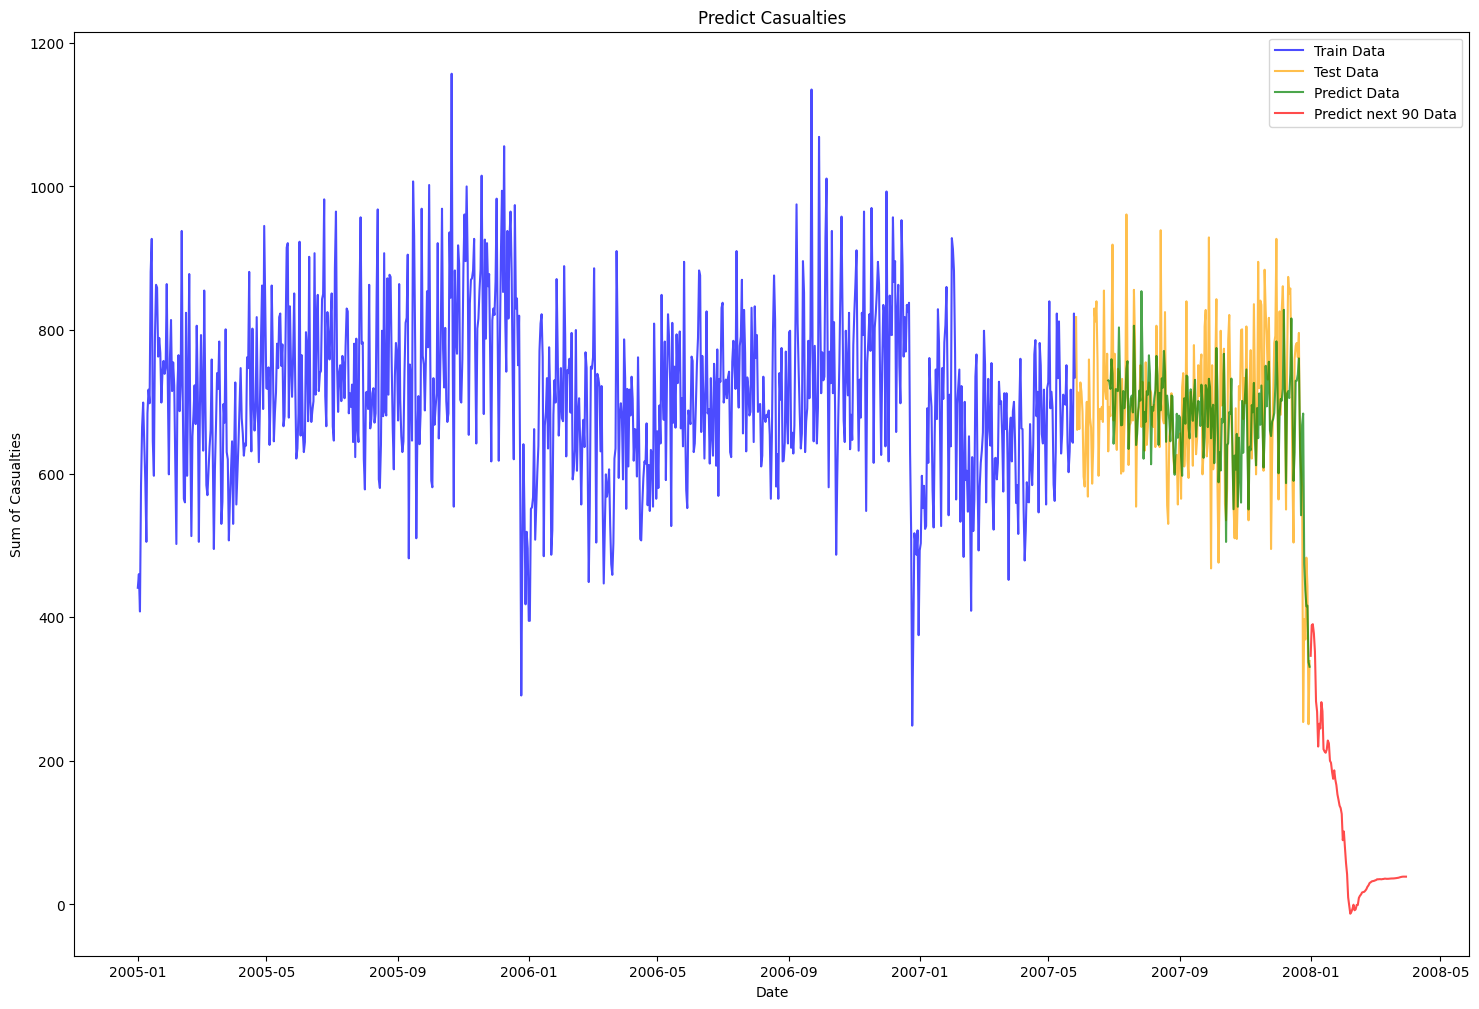

In [68]:
test_predictions_pd = test_prediction.select("Date", "Prediction").toPandas()
next90_predict_pd = prediction_next90.select("Date", "Prediction").toPandas()
train_pandas = train_data.select("Date", "sum_Casualties").toPandas()
test_pandas = test_data1.select("Date", "sum_Casualties").toPandas()

train_pandas['Date'] = pd.to_datetime(train_pandas['Date'])
test_pandas['Date'] = pd.to_datetime(test_pandas['Date'])
test_predictions_pd['Date'] = pd.to_datetime(test_predictions_pd['Date'])
next90_predict_pd['Date'] = pd.to_datetime(next90_predict_pd['Date'])

plt.figure(figsize=(18, 12))
plt.plot(train_pandas['Date'], train_pandas['sum_Casualties'], label='Train Data', color='blue', alpha=0.7)
plt.plot(test_pandas['Date'], test_pandas['sum_Casualties'], label='Test Data', color='orange', alpha=0.7)
plt.plot(test_predictions_pd['Date'], test_predictions_pd['Prediction'], label='Predict Data', color='green', alpha=0.7)
plt.plot(next90_predict_pd['Date'], next90_predict_pd['Prediction'], label='Predict next 90 Data', color='red', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Sum of Casualties")
plt.title("Predict Casualties")
plt.legend()

plt.show()